## ICU Length of stay using LightGBM Model &  Tranformer Models

In [ ]:
import math
#import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import fetch_california_housing
#import tensorflow_addons as tfa
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)
import warnings
warnings.filterwarnings('ignore')


#from tensorflow.keras.callbacks import EarlyStopping

#from tabtransformertf.models.fttransformer import FTTransformerEncoder, FTTransformer
#from tabtransformertf.utils.preprocessing import df_to_dataset

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)
import warnings
warnings.filterwarnings('ignore')
## reading careplans csv
#/content/gdrive/MyDrive/Colab Notebooks/covid/100k_synthea_covid19_csv/allergies.csv

In [ ]:
devices = pd.read_csv("100k_synthea_covid19_csv/devices.csv")
devices_test = pd.read_csv("10k_synthea_covid19_csv/devices.csv")

imaging_studies = pd.read_csv("100k_synthea_covid19_csv/imaging_studies.csv")
imaging_studies_test = pd.read_csv("10k_synthea_covid19_csv/imaging_studies.csv")

immunizations = pd.read_csv("100k_synthea_covid19_csv/immunizations.csv")
immunizations_test = pd.read_csv("10k_synthea_covid19_csv/immunizations.csv")

medications = pd.read_csv("100k_synthea_covid19_csv/medications.csv")
medications_test = pd.read_csv("10k_synthea_covid19_csv/medications.csv")

providers = pd.read_csv("100k_synthea_covid19_csv/providers.csv")
providers_test = pd.read_csv("10k_synthea_covid19_csv/providers.csv")

allergies = pd.read_csv("100k_synthea_covid19_csv/allergies.csv")
allergies_test = pd.read_csv("10k_synthea_covid19_csv/allergies.csv")

conditions = pd.read_csv("100k_synthea_covid19_csv/conditions.csv")
conditions_test = pd.read_csv("10k_synthea_covid19_csv/conditions.csv")

patients = pd.read_csv("100k_synthea_covid19_csv/patients.csv")
patients_test = pd.read_csv("10k_synthea_covid19_csv/patients.csv")

encounters = pd.read_csv("100k_synthea_covid19_csv/encounters.csv")
encounters_test = pd.read_csv("10k_synthea_covid19_csv/encounters.csv")


In [ ]:
def patients_reader(data, goal):
    data.DEATHDATE.fillna("2021-01-01", inplace = True) 
    data.DEATHDATE = pd.to_datetime(data["DEATHDATE"])
    data.BIRTHDATE =  pd.to_datetime(data["BIRTHDATE"])
    data["age"] =data.DEATHDATE- data.BIRTHDATE
    data['age'] = data.age.astype('timedelta64[Y]').astype('int')
    data["healthcare_coverage_ratio"] = data.HEALTHCARE_COVERAGE / data.HEALTHCARE_EXPENSES
    data["dataset"] = goal
    data.MARITAL.fillna("S", inplace = True)
    data.drop_duplicates(inplace = True) 
    data = data[['Id', "age", "MARITAL", "RACE", "ETHNICITY", "GENDER", "CITY", "COUNTY", "healthcare_coverage_ratio"]]
    #data = data.rename(columns = {"Id": "patient"})
    return data

patients = pd.read_csv("100k_synthea_covid19_csv/patients.csv")
patients_test = pd.read_csv("10k_synthea_covid19_csv/patients.csv")
patients = patients_reader(patients, "train")
patients_test = patients_reader(patients_test, "test")

In [ ]:
def icu_preparation(encounter, condition, patient):
    covid_patient_ids = condition[condition.CODE == 840539006].PATIENT.unique()
    covid_conditions = condition[condition.CODE == 840539006]
    cp = covid_conditions.merge(patient, how='left', left_on='PATIENT', right_on='Id')
    icu_ids = encounter[encounter.CODE == 305351004].PATIENT
    cp['icu_admit'] = cp.Id.isin(icu_ids)
    icu_only = cp[cp.icu_admit == True]
    icu_only.START = pd.to_datetime(icu_only.START)
    icu_only.STOP = pd.to_datetime(icu_only.STOP)
    icu_only["duration"] = (icu_only.STOP - icu_only.START).dt.days
    icu_only = icu_only.loc[icu_only.STOP.notnull()].reset_index(drop = True)
    #icu_only["age"] = pd.to_datetime(icu_only["DEATHDATE"]) - pd.to_datetime(icu_only["BIRTHDATE"])
    #icu_only["healthcare_coverage_ratio"] = icu_only.HEALTHCARE_COVERAGE / icu_only.HEALTHCARE_EXPENSES
    needed_columns = ["START", "STOP", "PATIENT", "MARITAL", "RACE", "ETHNICITY", "GENDER", "CITY", "COUNTY", "healthcare_coverage_ratio" ,
                      "duration"]

    df = icu_only[needed_columns]
    return df

In [ ]:
df = icu_preparation(encounters, conditions, patients)
test = icu_preparation(encounters_test, conditions_test, patients_test)

In [ ]:
df.head()

In [ ]:
df = df.rename(columns = {"START" : "icu_start", "STOP" : "icu_stop"})
test = test.rename(columns = {"START" : "icu_start", "STOP" : "icu_stop"})

In [ ]:
def patients_reader(data, goal):
    data.DEATHDATE.fillna("2021-01-01", inplace = True) 
    data.DEATHDATE = pd.to_datetime(data["DEATHDATE"])
    data.BIRTHDATE =  pd.to_datetime(data["BIRTHDATE"])
    data["age"] =data.DEATHDATE- data.BIRTHDATE
    data['age'] = data.age.astype('timedelta64[Y]').astype('int')
    data["healthcare_coverage_ratio"] = data.HEALTHCARE_COVERAGE / data.HEALTHCARE_EXPENSES
    data["dataset"] = goal
    data.MARITAL.fillna("S", inplace = True)
    data.drop_duplicates(inplace = True) 
    data = data[['Id', "age", "MARITAL", "RACE", "ETHNICITY", "GENDER", "CITY", "COUNTY", "healthcare_coverage_ratio"]]
    #data = data.rename(columns = {"Id": "patient"})
    return data

In [ ]:
patients = pd.read_csv("100k_synthea_covid19_csv/patients.csv")
patients_test = pd.read_csv("10k_synthea_covid19_csv/patients.csv")
patients = patients_reader(patients, "train")
patients_test = patients_reader(patients_test, "test")

In [ ]:
def mode_finder(x): 
    m = pd.Series.mode(x); 
    return m.values[0] if not m.empty else np.nan

In [ ]:
# Careplan

careplan_df = pd.read_csv("100k_synthea_covid19_csv/careplans.csv")
careplan_df_test = pd.read_csv("10k_synthea_covid19_csv/careplans.csv")

careplan_df.DESCRIPTION = careplan_df.DESCRIPTION.apply(lambda x : x.replace("(", ""))
careplan_df.DESCRIPTION = careplan_df.DESCRIPTION.apply(lambda x : x.replace(")", ""))

careplan_df_test.DESCRIPTION = careplan_df_test.DESCRIPTION.apply(lambda x : x.replace("(", ""))
careplan_df_test.DESCRIPTION = careplan_df_test.DESCRIPTION.apply(lambda x : x.replace(")", ""))

def careplan_reader(data, goal):
    data = data[["PATIENT", "START", "STOP", "DESCRIPTION", "REASONDESCRIPTION"]]
    data.columns = ["patient", "careplan_start", "careplan_end", "careplan_desc", "careplan_reason"]
    if goal == "train":
        for i in data.careplan_desc.value_counts().index[:10]:
            name = i
            data.loc[data.careplan_desc.astype(str).str.contains(i[:15]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
    else:
      for i in careplan_df.careplan_desc.value_counts().index[:10]:
            name =  i
            data.loc[data.careplan_desc.astype(str).str.contains(i[:15]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")

            data[name].fillna(0, inplace = True)
    data["patient's most seen careplan"] = data.groupby("patient")["careplan_desc"].transform(mode_finder)
    data = data.loc[data.careplan_reason == "COVID-19"].reset_index(drop = True)
        
    
    data["dataset"] = goal
    
    data.drop_duplicates(inplace = True) 
    return data

careplan_df = careplan_reader(careplan_df, "train")
careplan_df_test = careplan_reader(careplan_df_test, "test")

In [ ]:
df = df.rename(columns = {"PATIENT" : "patient"})
test = test.rename(columns = {"PATIENT" : "patient"})

In [ ]:

careplan_df = pd.merge(careplan_df, df,  on='patient', how = "right")

careplan_df_test = pd.merge(careplan_df_test, test,  on='patient', how = "right")

In [ ]:
#Conditions

conditions_df = pd.read_csv("100k_synthea_covid19_csv/conditions.csv")
conditions_df_test = pd.read_csv("10k_synthea_covid19_csv/conditions.csv")

conditions_df['DESCRIPTION'] = conditions_df['DESCRIPTION'].str.replace("(","")
conditions_df['DESCRIPTION'] = conditions_df['DESCRIPTION'].str.replace(")","")
                                                                           
conditions_df_test['DESCRIPTION'] = conditions_df_test['DESCRIPTION'].str.replace("(","")
conditions_df_test['DESCRIPTION'] = conditions_df_test['DESCRIPTION'].str.replace(")","")
features = conditions_df.DESCRIPTION.value_counts().index[:40]

def condition_reader(data, train = True):
    data = data[["PATIENT", "START", "STOP", "DESCRIPTION"]]
    data.columns = ["patient", "condition_start", "condition_stop", "condition_desc"]
    data.condition_start = pd.to_datetime(data.condition_start)
    data.condition_stop = pd.to_datetime(data.condition_stop)
    if train == True:
        for i in features:
            name = "patient's_condition_of_" + i
            data.loc[data.condition_desc.astype(str).str.contains(i[:10]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
    else:
        for i in features:
            name = "patient's_condition_of_" + i
            data.loc[data.condition_desc.astype(str).str.contains(i[:10]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
        
    data["patient's most seen condition"] = data.groupby("patient")["condition_desc"].transform(mode_finder)
    data["condition_duration"] = (data.condition_stop - data.condition_start).dt.days
    data["patient_condition_count"] = data.groupby("patient")["condition_desc"].transform("count") # how many conditions?
    data["patient_condition_unique"] = data.groupby("patient")["condition_desc"].transform("nunique") # how many unique conditions?
    data["patient_condition_days_avg"] = data.groupby("patient")["condition_duration"].transform("mean") # avg. day under conditions?
    data["patient_condition_days_sum"] = data.groupby("patient")["condition_duration"].transform("sum")
    data.drop_duplicates(subset = "patient", inplace = True) 
    return data

conditions_df = condition_reader(conditions_df)
conditions_df_test = condition_reader(conditions_df_test)

In [ ]:
needed_columns = []
for i in conditions_df.columns:
    if "patient" in i:
        needed_columns.append(i)
        
        
conditions_df = conditions_df[needed_columns].drop_duplicates()
conditions_df_test = conditions_df_test[needed_columns].drop_duplicates()

In [ ]:
conditions_df.head()

In [ ]:
medications_df = pd.read_csv("100k_synthea_covid19_csv/medications.csv")
medications_df_test = pd.read_csv("10k_synthea_covid19_csv/medications.csv")
features = medications_df.DESCRIPTION.value_counts().index[:30]

def medication_reader(data, train = True):
    
    data = data[["PATIENT", "START", "STOP", "DESCRIPTION", "TOTALCOST", "REASONDESCRIPTION"]]
    data.columns = ["patient", "med_start", "med_stop", "med_desc", "med_total_cost", "med_reason"]
    data.med_start = pd.to_datetime(data.med_start)
    data.med_stop = pd.to_datetime(data.med_stop)
    data.med_desc = data.med_desc.replace([")", "("], "")
    if train == True:
        for i in features:
            name = "patient's_medication_of_" + i
            data.loc[data.med_desc.astype(str).str.contains(i[:15]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
    else:
        for i in features:
            name = "patient's_medication_of_" + i
            data.loc[data.med_desc.astype(str).str.contains(i[:15]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
        
    data["patient's most used medication"] = data.groupby("patient")["med_desc"].transform(mode_finder)
    data["patient's most usage reason"] = data.groupby("patient")["med_reason"].transform(mode_finder)
    data["med_duration"] = (data.med_stop - data.med_start).dt.days + 1
    data["total_med_duration_of_patient"] = data.groupby("patient")["med_duration"].transform("sum")
    data["total_med_cost_of_patient"] = data.groupby("patient")["med_total_cost"].transform("sum")
    data["total_med_count_of_patient"] = data.groupby("patient")["med_desc"].transform("count")
    data["total_unique_med_of_patient"] = data.groupby("patient")["med_desc"].transform("nunique")
    data.drop_duplicates(subset = "patient", inplace = True) 
    return data
        

medications_df = medication_reader(medications_df)
medications_df_test = medication_reader(medications_df_test, train = "False")

In [ ]:
needed_columns = []
for i in medications_df.columns:
    if "patient" in i:
        needed_columns.append(i)
medications_df = medications_df[needed_columns].drop_duplicates()
medications_df_test = medications_df_test[needed_columns].drop_duplicates()

In [ ]:
#Observations

observations_df = pd.read_csv("100k_synthea_covid19_csv/observations.csv").sample(frac = 0.001)
observations_df_test = pd.read_csv("10k_synthea_covid19_csv/observations.csv").sample(frac = 0.001)
observations_df_test.DESCRIPTION = observations_df_test.DESCRIPTION.replace([")", "/", "[", "/", "]",  "#","("], "")
observations_df.DESCRIPTION = observations_df.DESCRIPTION.replace([")", "/", "[", "/", "]",  "#","("], "")
observations_df["DESCRIPTION"] = observations_df["DESCRIPTION"].str.strip()     
observations_df["DESCRIPTION"] = observations_df["DESCRIPTION"].str.replace(' ', '_')         
observations_df["DESCRIPTION"] = observations_df["DESCRIPTION"].str.replace(r"[^a-zA-Z\d\_]+", "")    
observations_df["DESCRIPTION"] = observations_df["DESCRIPTION"].str.replace(r"[^a-zA-Z\d\_]+", "")
features = observations_df.DESCRIPTION.value_counts().index[:30]

def observation_reader(data,  train = True):
    data = data[["DATE", "PATIENT", "DESCRIPTION", "VALUE"]]
    data.columns = ["obs_date", "patient", "obs_desc", "obs_value"]
    data.obs_value.fillna(0, inplace = True)
    data.obs_desc = data.obs_desc.replace([")", "("], "")

    if train == True:
        for i in features:
            name = "patient's_observation_of_" + i
            data.loc[data.obs_desc.astype(str).str.contains(i[:15]), name] = data.loc[data.obs_desc.astype(str).str.contains(i[:15])].groupby("patient")["obs_value"].transform(mode_finder)
            #data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
            
    else:
        for i in features:
            name = "patient's_observation_of_" + i
            data.loc[data.obs_desc.astype(str).str.contains(i[:15]), name] = data.loc[data.obs_desc.astype(str).str.contains(i[:15])].groupby("patient")["obs_value"].transform(mode_finder)
            #data[name] = data.groupby("patient")[name].transform("max")

            data[name].fillna(0, inplace = True)
    
    data["patient's most seen observation"] = data.groupby("patient")["obs_desc"].transform(mode_finder)

    data["patient_obs_count"] = data.groupby("patient")["obs_desc"].transform("count")
    data["patient_obs_count_unique"] = data.groupby("patient")["obs_desc"].transform("nunique")   
    data.drop_duplicates(subset = "patient", inplace = True) 
    return data



In [ ]:
observations_df = observation_reader(observations_df)
observations_df_test = observation_reader(observations_df_test, train =  "False")

In [ ]:
needed_columns = []
for i in observations_df.columns:
    if "patient" in i:
        needed_columns.append(i)
observations_df = observations_df[needed_columns].drop_duplicates()
observations_df_test = observations_df_test[needed_columns].drop_duplicates()

In [ ]:
observations_df.head()

In [ ]:
#Allergies
features = allergies.DESCRIPTION.value_counts().index[:10]

def allergies_reader(data, feature = "DESCRIPTION", train = True):
      data["unique_allergies_per_patient"] = data.groupby(["PATIENT"])[feature].transform("nunique")
      data = data.rename(columns = {"PATIENT" : "patient"})
      if train == True:
            for i in features:
                  name = "patient's_alergy_of_" + i
                  data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
                  data[name] = data.groupby("patient")[name].transform("max")

                  data[name].fillna(0, inplace = True)
      else:
        for i in features:
                  name = "patient's_alergy_of_" + i
                  data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
                  data[name] = data.groupby("patient")[name].transform("max")

                  data[name].fillna(0, inplace = True)
      data["patient's most seen allergy"] = data.groupby("patient")["DESCRIPTION"].transform(mode_finder)

      return data
allergies_df = allergies_reader(allergies, "DESCRIPTION")
allergies_test_df = allergies_reader(allergies_test, "DESCRIPTION")

In [ ]:
allergies_df.head()

In [ ]:
#Imaging Studies

def imaging_studies_reader(df):
        df = df[["PATIENT", "BODYSITE_DESCRIPTION", "MODALITY_DESCRIPTION"]]

        for i in df.MODALITY_DESCRIPTION.unique():
            df.loc[df.MODALITY_DESCRIPTION == i, i] = 1
        df.fillna(0, inplace = True)
        for i in ['Digital Radiography', 'Ultrasound', 'Computed Radiography',
            'Computed Tomography']:
            name = "patient's " + i + "count"
            df[name] = df.groupby("PATIENT")[i].transform("sum")
        df = df.drop(['Digital Radiography', 'Ultrasound', 'Computed Radiography',
            'Computed Tomography', "MODALITY_DESCRIPTION"], 1)
        df["patient's_different_bodysite_imaging_studies"] = df.groupby("PATIENT")["BODYSITE_DESCRIPTION"].transform("nunique")
        df.drop(["BODYSITE_DESCRIPTION"], 1, inplace = True)
        df = df.rename(columns = {"PATIENT" : "patient"})
        return df
imaging_studies_df = imaging_studies_reader(imaging_studies)
imaging_studies_test_df = imaging_studies_reader(imaging_studies_test)

In [ ]:
#Immunizations
def immunizations_reader(df):
    df["unique_immunizations"] = df.groupby("PATIENT")["DESCRIPTION"].transform("nunique")
    df = df[["PATIENT", "unique_immunizations"]]  
    df = df.rename(columns = {"PATIENT" : "patient"})
    return df

In [ ]:
immunizations_df = immunizations_reader(immunizations)
immunizations_test_df = immunizations_reader(immunizations_test)

In [ ]:
encounters = pd.read_csv("100k_synthea_covid19_csv/encounters.csv")
encounters_test = pd.read_csv("10k_synthea_covid19_csv/encounters.csv")


In [ ]:
features = encounters.DESCRIPTION.value_counts().index[:15]


def encounters_reader(data, train = True):
    data = data[["PATIENT", "ENCOUNTERCLASS", "DESCRIPTION"]]
    data["unique_encounters_per_patient"] = data.groupby("PATIENT")["DESCRIPTION"].transform("nunique")
    data = data.rename(columns = {"PATIENT": "patient"})
    if train == True:
      for i in features:
          name = i
          data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("max")
          data[name].fillna(0, inplace = True)
      for i in data.ENCOUNTERCLASS.unique():
          name = i
          data.loc[data.ENCOUNTERCLASS.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("sum")
          data[name].fillna(0, inplace = True)
    else:
      for i in features:
          name =  i
          data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("sum")
          data[name].fillna(0, inplace = True)
      for i in devices.ENCOUNTERCLASS.unique():
          name = i
          data.loc[data.ENCOUNTERCLASS.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("sum")
          data[name].fillna(0, inplace = True)
    
    data["patient's most seen encounter"] = data.groupby("patient")["DESCRIPTION"].transform(mode_finder)

    return data



encounters_df = encounters_reader(encounters)
encounters_df_test = encounters_reader(encounters_test)

In [ ]:
encounters_df.head()

In [ ]:
#Providers
def provider_reader(df):
    df = df[["Id", "CITY"]]
    df["doctor_count_per_city"] = df.groupby("CITY")["Id"].transform("nunique")
    df = df[["CITY", "doctor_count_per_city"]]
    return df

In [ ]:
providers_df = provider_reader(providers)
providers_df_test = provider_reader(providers_test)

In [ ]:
#Devices
def devices_reader(data, train = True):
    data = data[["PATIENT", "DESCRIPTION"]]
    data["used_unique_device_per_patient"] = data.groupby("PATIENT")["DESCRIPTION"].transform("nunique")
    data = data.rename(columns = {"PATIENT": "patient"})
    if train == True:
      for i in data.DESCRIPTION.value_counts().index[:10]:
          name = i
          data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("max")
          data[name].fillna(0, inplace = True)
    else:
      for i in devices.DESCRIPTION.value_counts().index[:10]:
          name =  i
          data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("max")

          data[name].fillna(0, inplace = True)
    data["patient's most used device"] = data.groupby("patient")["DESCRIPTION"].transform(mode_finder)


    return data

In [ ]:
devices_df = devices_reader(devices)
devices_df_test = devices_reader(devices_test)

Merging

In [ ]:
merged_train= pd.merge(df, conditions_df, on = ["patient"])
merged_train= pd.merge(merged_train, observations_df, on = ["patient"])
merged_train= pd.merge(merged_train, medications_df, on = ["patient"])
merged_train= pd.merge(merged_train, devices_df, on = ["patient"], how = "left")
merged_train= pd.merge(merged_train, immunizations_df, on = ["patient"], how = "left")
merged_train= pd.merge(merged_train, imaging_studies_df, on = ["patient"], how = "left")
merged_train= pd.merge(merged_train, allergies_df, on = ["patient"], how = "left")
merged_train= pd.merge(merged_train, providers_df, on = ["CITY"], how = "left")
merged_train = merged_train.drop(["START", "STOP"],1)

In [ ]:
test = test.rename(columns = {"START": "icu_start", "STOP" : "icu_stop"})
merged_test= pd.merge(test, conditions_df_test, on = ["patient"])
merged_test= pd.merge(merged_test, observations_df_test, on = ["patient"])
merged_test= pd.merge(merged_test, medications_df_test, on = ["patient"])
merged_test= pd.merge(merged_test, devices_df_test, on = ["patient"], how = "left")
merged_test= pd.merge(merged_test, immunizations_test_df, on = ["patient"], how = "left")
merged_test= pd.merge(merged_test, imaging_studies_test_df, on = ["patient"], how = "left")
merged_test= pd.merge(merged_test, allergies_test_df, on = ["patient"], how = "left")
merged_test= pd.merge(merged_test, providers_df_test, on = ["CITY"], how = "left")
merged_test = merged_test.drop(["START", "STOP"],1)

In [ ]:
merged_train = merged_train.drop_duplicates(subset = ["patient", "duration"]).reset_index(drop = True)
merged_test = merged_test.drop_duplicates(subset = ["patient", "duration"]).reset_index(drop = True)

In [ ]:
merged_train["dataset"] = "train"
merged_test["dataset"] = "test"

In [ ]:
data = pd.concat([merged_train,merged_test]).reset_index(drop = True).drop(["DESCRIPTION_x", "DESCRIPTION_y"],1)

In [ ]:
print("We have {} unique patients.".format(data.patient.nunique()))

In [ ]:
data.fillna(0, inplace = True)

In [ ]:
data.head()

In [ ]:
df = data.copy()
df.head()

### Let's create our target feature, careplan duration


In [ ]:
y = df['duration']
LABEL = "duration"

In [ ]:
# We are dropping duplicate values based on patient id's. 

df = df.drop_duplicates(subset = ["patient"]).reset_index(drop = True)

In [ ]:
df.head()

In [ ]:
#Correlation plot between features

corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

### seems like patient's past condition data will play a huge role in model.

In [ ]:
nums = df.select_dtypes(include=np.number).columns.tolist()
NUMERIC_FEATURES = []
for i in nums:
  if i not in ["careplan_duration", "duration", "CODE"]:
    NUMERIC_FEATURES.append(i)

In [ ]:
NUMERIC_FEATURES

In [ ]:
cats = df.select_dtypes(exclude=np.number).columns.tolist()
CATEGORICAL_FEATURES = []
for i in cats:
  if i not in ["patient", "careplan_start", "careplan_end","icu_start", "icu_stop", "dataset", "START", "STOP", "ENCOUNTER"]:
    CATEGORICAL_FEATURES.append(i)

In [ ]:
CATEGORICAL_FEATURES

In [ ]:
for i in list(df.select_dtypes(['object']).columns):
  df[i] = df[i].astype("category")

## LightGBM

##### Let's start with initial LightGBM model. After seeing the feature importance plot, we will reduce features to top 40. Then we will see if it performs better with top40 features

In [ ]:
#df = df.drop(["DESCRIPTION_x", "DESCRIPTION_y"], 1)
#df.fillna(0, inplace = True)
for i in df.columns:
  if i in CATEGORICAL_FEATURES:
    df[i] = df[i].astype(str)
    df[i].fillna(0, inplace = True)
    df[i] = df[i].astype("category")
train = df.loc[(df.dataset == "train") & (df.duration.notnull())]
test = df.loc[(df.dataset == "test") & (df.duration.notnull())]
for i in list(df.select_dtypes(['object']).columns):
  df[i] = df[i].astype("category")

In [ ]:

### Train & Validation 
from sklearn.model_selection import train_test_split
FEATURES = NUMERIC_FEATURES + CATEGORICAL_FEATURES
X = train.drop(["duration",  "ENCOUNTER","dataset",  "patient", "icu_start", "icu_stop"],1)[FEATURES]
y = train.duration
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .2, random_state = 42)

import lightgbm as lgb

model = lgb.LGBMRegressor()
model.fit(X_train, y_train, categorical_feature=CATEGORICAL_FEATURES)

preds = model.predict(X_val)
preds[preds<0] = 0
val_result = mean_squared_error(y_val, preds, squared= False)
val_result

In [ ]:
model.fit(X, y)
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score
real_preds = model.predict(test.drop(["duration",  "ENCOUNTER","dataset",  "patient", "icu_start", "icu_stop"],1)[FEATURES])
lgb_rmse = mean_squared_error(test.duration, real_preds, squared= False)
lgb_mae = mae(test.duration, real_preds)
lgb_r2 = r2_score(test.duration, real_preds)


lgb_rmse

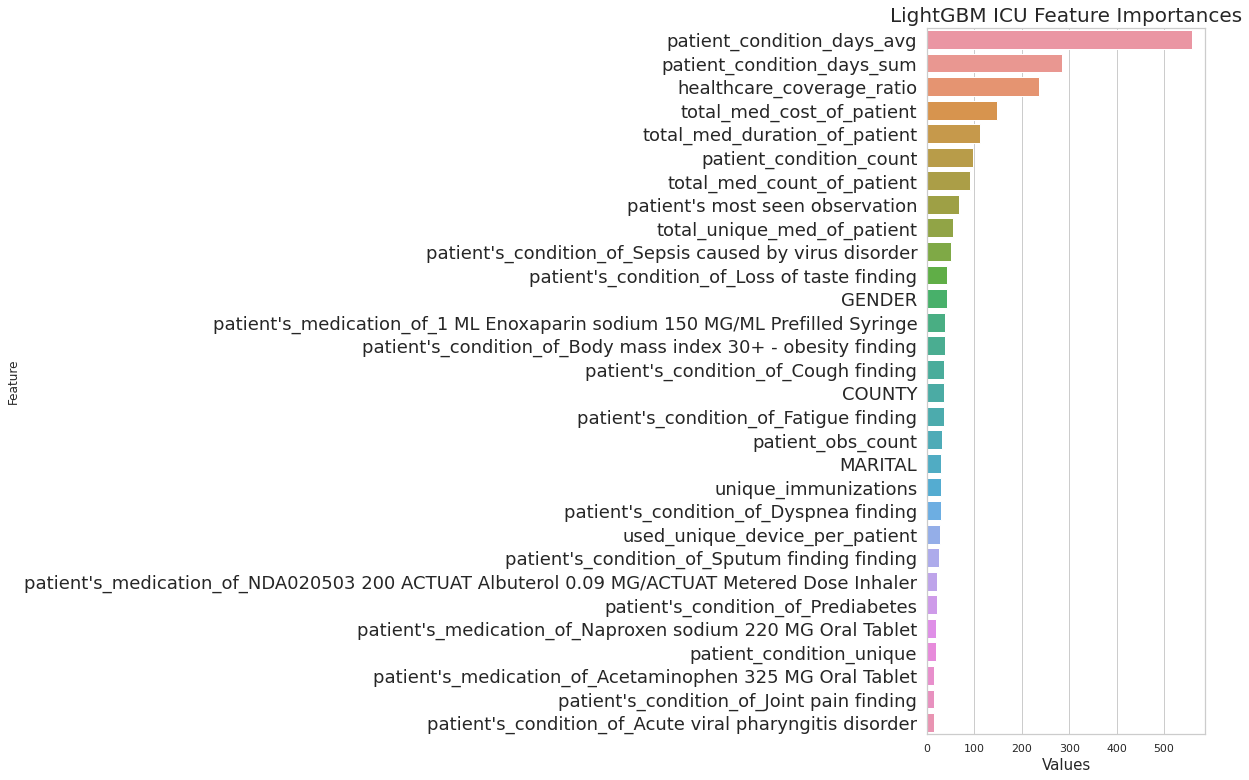

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(17, 11))
p = sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:10])
_, ylabels = plt.yticks()
p.set_yticklabels(ylabels, size=18)
p.set_xlabel("Values", size = 15)

plt.title('LightGBM ICU Feature Importances', fontsize = 20)
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importance-hospital.png')

In [ ]:
top30_features = feature_imp.sort_values("Value", ascending = False)[:30].Feature.values.tolist()
reduced_categorical_features = []
reduced_numerical_features = []
for i in top30_features:
  if i in CATEGORICAL_FEATURES:
    reduced_categorical_features.append(i)
  else:
    reduced_numerical_features.append(i)

In [ ]:
FEATURES = list(reduced_numerical_features) + list(reduced_categorical_features)

In [ ]:
X = train.drop(["duration",  "ENCOUNTER","dataset",  "patient", "icu_start", "icu_stop"],1)[FEATURES]
y = train.duration
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .2, random_state = 42)

model = lgb.LGBMRegressor()
model.fit(X_train, y_train, categorical_feature=reduced_categorical_features)

preds = model.predict(X_val)
preds[preds<0] = 0
val_result = mean_squared_error(y_val, preds, squared= False)
val_result

1.359869416755811

In [ ]:
model.fit(X, y)
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score
real_preds = model.predict(test.drop(["duration",  "ENCOUNTER","dataset",  "patient", "icu_start", "icu_stop"],1)[FEATURES])
lgb_rmse = mean_squared_error(test.duration, real_preds, squared= False)
lgb_mae = mae(test.duration, real_preds)
lgb_r2 = r2_score(test.duration, real_preds)


lgb_rmse

1.2977300874781035

#### It's indeed performing a bit better than initial model, by looking at both validation and test result we can say that

#### Let's tune some hyperparameters!

In [ ]:
### Parameter Optimization
params = {
        'min_child_weight': [1, 5, 10,15],
        'colsample_bytree': [0.5, 0.7, 0.99],
        'num_leaves': [4,8,16,32,64,80],
        'num_iterations': [100,500,1000],
        'max_depth': [3, 4, 5,6,7, 10],
        "reg_lambda" : [0.2,0.5, 1, 1.5]
        }
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold, KFold
param_comb = 10

kf = KFold(n_splits = 5)

random_search = RandomizedSearchCV(model, param_distributions=params, n_iter=10, scoring='neg_mean_squared_error',  cv=kf.split(X,y), verbose=1, random_state=42 )

# Here we go
random_search.fit(X, y)
import lightgbm as lgb

model = lgb.LGBMRegressor(**random_search.best_params_)
model.fit(X_train, y_train, categorical_feature=reduced_categorical_features)

preds = model.predict(X_val)
val_result2 = mean_squared_error(y_val, preds, squared= False)
val_result2
print(random_search.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'reg_lambda': 1.5, 'num_leaves': 4, 'num_iterations': 100, 'min_child_weight': 1, 'max_depth': 10, 'colsample_bytree': 0.7}


{'reg_lambda': 0.2, 'num_leaves': 8, 'num_iterations': 500, 'min_child_weight': 1, 'max_depth': 4, 'colsample_bytree': 0.99}

In [ ]:
import lightgbm as lgb

model = lgb.LGBMRegressor(**random_search.best_params_)
model.fit(X_train, y_train, categorical_feature=reduced_categorical_features)

preds = model.predict(X_val)
val_result2 = mean_squared_error(y_val, preds, squared= False)
print("Validation Result {}".format(val_result2))
##Test
model.fit(X, y)

real_preds = model.predict(test.drop(["duration",  "ENCOUNTER","dataset",  "patient", "icu_start", "icu_stop"],1)[FEATURES])
lgb_tuned_rmse = mean_squared_error(test.duration, real_preds, squared= False)
lgb_tuned_mae = mae(test.duration, real_preds)
lgb_tuned_r2 = r2_score(test.duration, real_preds)
print("Test Result {}".format(lgb_tuned_rmse))

Validation Result 1.3083857225323534
Test Result 1.4283061680553601


In [ ]:
df["start_month"] = df.icu_start.dt.month
df["start_week"] = df.icu_start.dt.week
df["start_day"] = df.icu_start.dt.dayofyear

test["start_month"] = test.icu_start.dt.month
test["start_week"] = test.icu_start.dt.week
test["start_day"] = test.icu_start.dt.dayofyear

Text(0, 0.5, '% difference between real values and predictions')

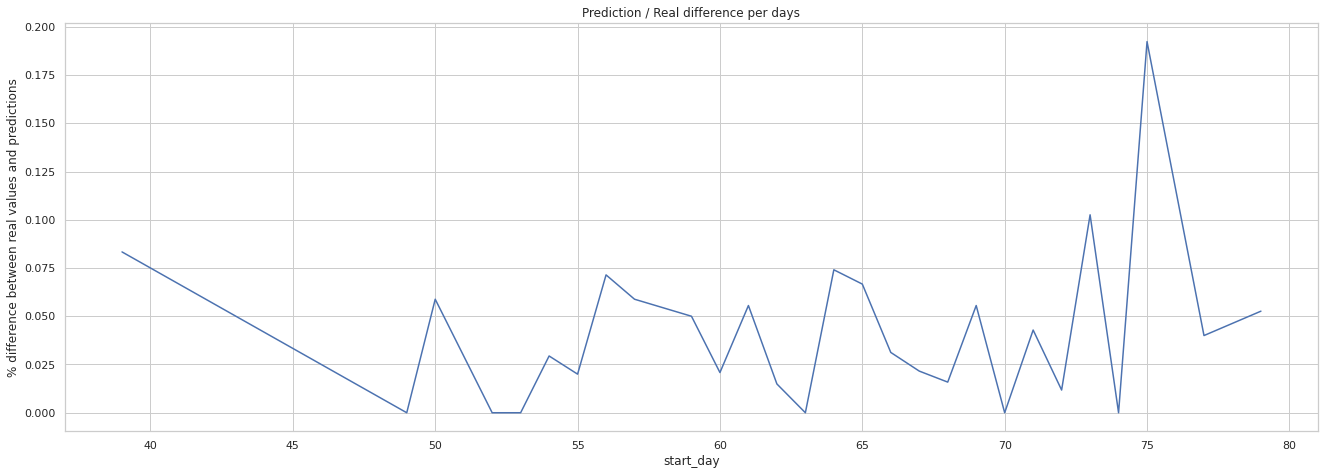

In [ ]:
test["preds"] = real_preds
test["daily_preds_sum"] = test.groupby("start_day")["preds"].transform("sum").astype(int)
test["daily_real_sum"] = test.groupby("start_day")["duration"].transform("sum")
temp = test.drop_duplicates(subset = ["start_day", "daily_preds_sum", "daily_real_sum"])[["start_day", "daily_preds_sum", "daily_real_sum"]].sort_values("start_day")
temp["daily_difference"] = abs(temp["daily_real_sum"] - temp["daily_preds_sum"])/temp.daily_real_sum
plt.figure(figsize = (20,7))
sns.lineplot(x = temp.start_day, y = temp.daily_difference)
plt.title("Prediction / Real difference per days")
plt.ylabel("% difference between real values and predictions")

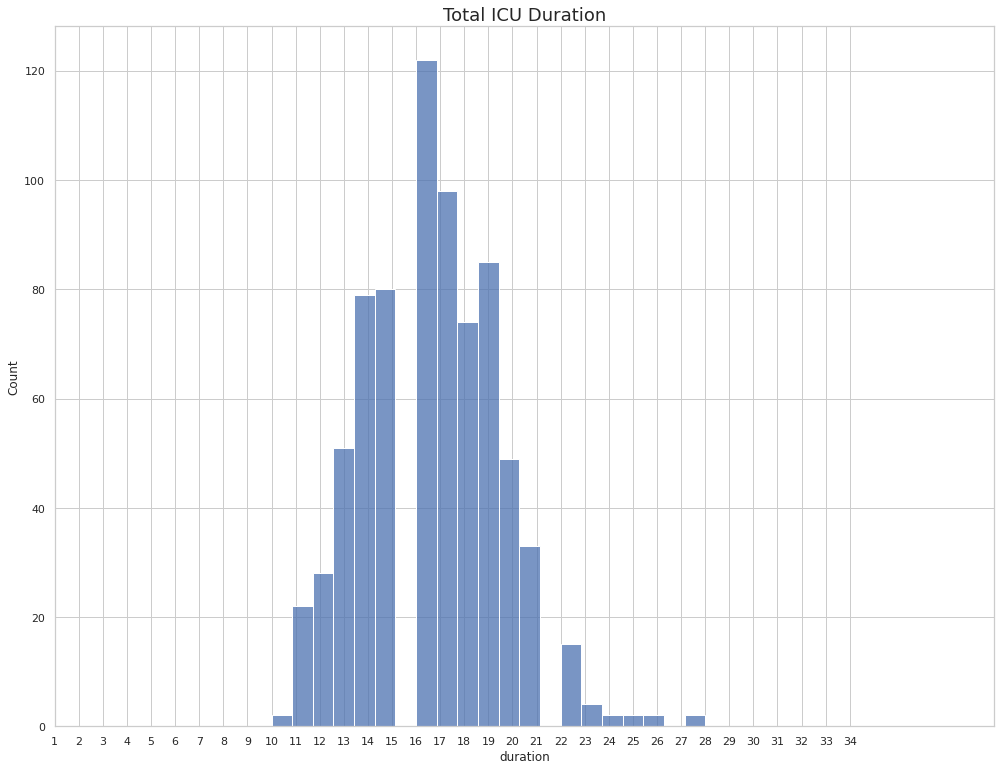

In [ ]:
plt.figure(figsize = (15,12))
sns.histplot(data = df, x = "duration")
plt.xticks(np.arange(1,35,1))
plt.xlim(1,40)
plt.title('Total ICU Duration', fontsize = 18)
plt.show()

Text(0, 0.5, 'frequency')

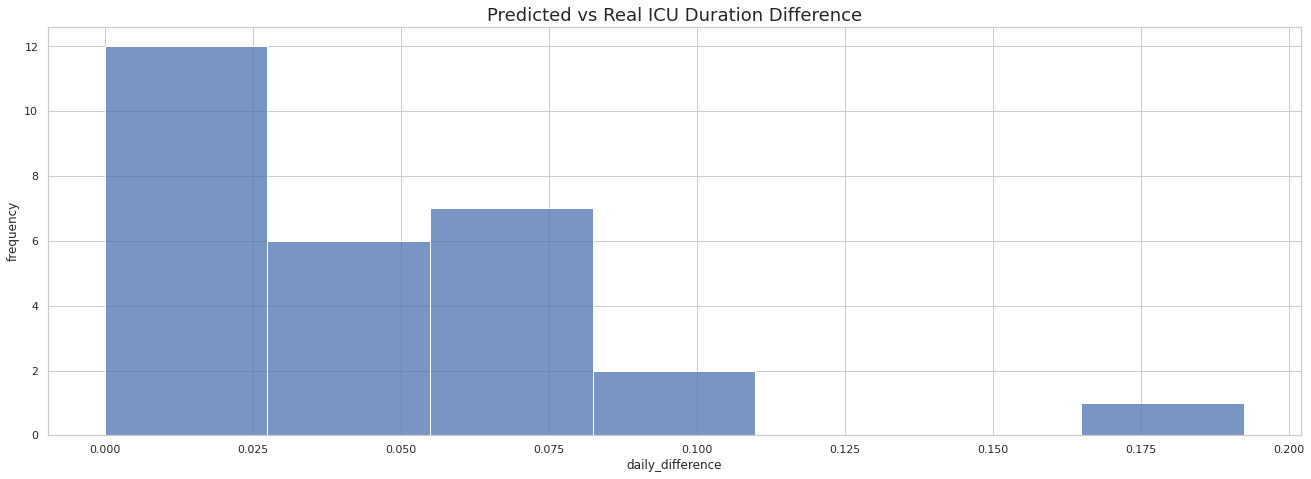

In [ ]:
plt.figure(figsize = (20,7))
sns.histplot(data = temp, x = "daily_difference")
plt.title("Predicted vs Real ICU Duration Difference", fontsize = 18)
plt.ylabel("frequency")

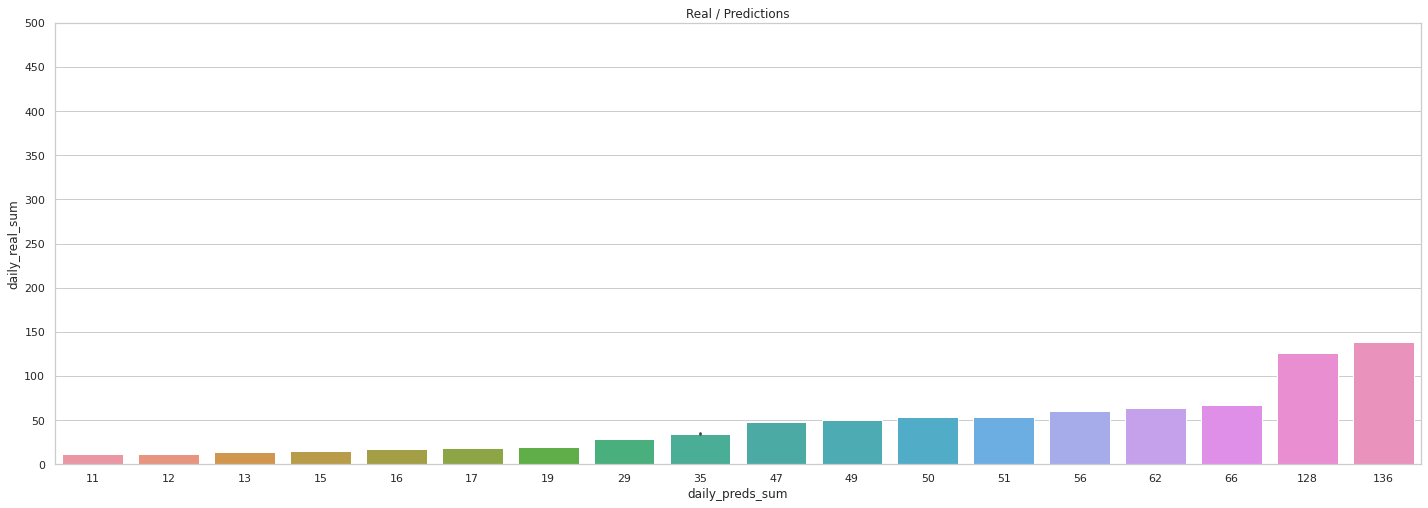

In [ ]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.daily_preds_sum[:20], y = temp.daily_real_sum[:20])
plt.tight_layout()
plt.yticks(np.arange(0,550,50))
plt.title("Real / Predictions")
plt.show()

Text(0.5, 1.0, 'Daily differences between real values and predictions')

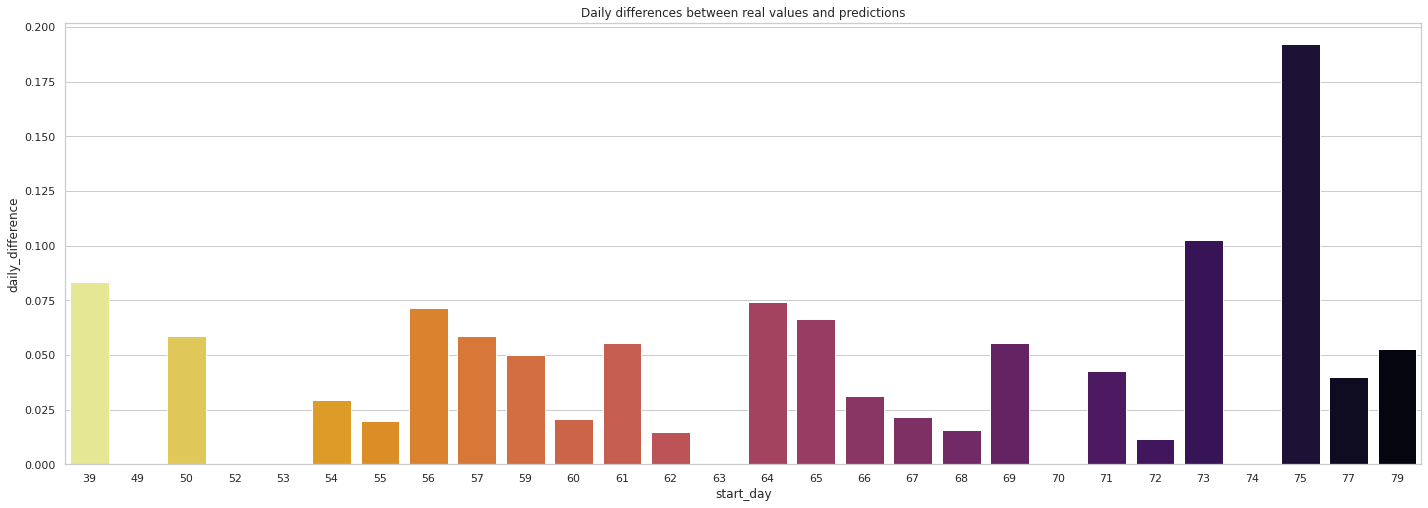

In [ ]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.start_day, y =temp.daily_difference, palette = "inferno_r")
plt.tight_layout()
plt.title("Daily differences between real values and predictions")

### FT - Transformer Models

In [ ]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.1 MB/s eta 0:00:00


In [ ]:
!pip install tabtransformertf


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import math
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import fetch_california_housing
import tensorflow_addons as tfa
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)
import warnings
warnings.filterwarnings('ignore')


from tensorflow.keras.callbacks import EarlyStopping

from tabtransformertf.models.fttransformer import FTTransformerEncoder, FTTransformer
from tabtransformertf.utils.preprocessing import df_to_dataset

#import catboost as cb
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

def cat_analyser(data, col, freq_limit = None):
    if freq_limit == None:
        freq_limit = data[col].nunique()
        if freq_limit >= 12:
            freq_limit = 12
    df_ = data.copy()
    sns.set(rc = {'axes.facecolor': 'gainsboro',
                  'figure.facecolor': 'gainsboro'})
    if freq_limit < 6 or col == "Year":
        if df_[col].nunique() > freq_limit:
            df_ = df_.loc[df_[col].isin(df_[col].value_counts(). \
                                        keys()[:freq_limit].tolist())]
        fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,7))
        plt.tight_layout()
        #fig.suptitle(col, fontsize = 16)
        a = sns.countplot(data = df_,
                    x = col,
                    ax = ax[0],
                    palette= "viridis",
                    order =  df_[col].value_counts().index)
        a.set_title(col, fontsize = 15)
        ax[0].set_xlabel('')
        pie_cmap = plt.get_cmap("Set3")
        normalize = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)) 
        data[col].value_counts()[:freq_limit].plot.pie(autopct = '%1.1f%%',
                                        textprops = {'fontsize': 12},
                                        ax = ax[1],
                                        colors = pie_cmap(normalize(df_[col].value_counts())))
        ax[1].set_ylabel('')
    
        plt.show()
        sns.reset_orig()
    else:
        fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18, freq_limit*1.5))
        #ax.set_title(col, fontsize = 16)
        a = sns.countplot(data = df_,
                    y = col,
                    ax = ax[0],
                    palette= "viridis",
                    order =  df_[col].value_counts()[:freq_limit].index)
        a.tick_params(axis = "x", rotation = 90)
        a.set_title(col, fontsize = 15)
        ax[0].set_xlabel('')
        pie_cmap = plt.get_cmap("Set3")
        normalize = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)) 
        data[col].value_counts()[:freq_limit].plot.pie(autopct = '%1.1f%%',
                                        textprops = {'fontsize': 12},
                                        ax = ax[1],
                                        colors = pie_cmap(normalize(df_[col].value_counts())))
        ax[1].set_ylabel('')
        plt.show()
        plt.tight_layout()
        sns.reset_orig()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)
import warnings
warnings.filterwarnings('ignore')



In [ ]:
data = df.copy()
data = data.loc[data.duration > 0].reset_index(drop = True)

In [ ]:
y = data['duration']
LABEL = "duration"

In [ ]:
test_data = data.loc[data.dataset == "test"].drop(["dataset"],1).reset_index(drop = True)
train_data = data.loc[data.dataset == "train"].drop(["dataset"],1).reset_index(drop = True)

In [ ]:
CATEGORICAL_FEATURES = reduced_categorical_features
NUMERIC_FEATURES = reduced_numerical_features

In [ ]:
CATEGORICAL_FEATURES

["patient's most seen observation", 'GENDER', 'COUNTY', 'MARITAL']

In [ ]:
NUMERIC_FEATURES

['patient_condition_days_avg',
 'patient_condition_days_sum',
 'healthcare_coverage_ratio',
 'total_med_cost_of_patient',
 'total_med_duration_of_patient',
 'patient_condition_count',
 'total_med_count_of_patient',
 'total_unique_med_of_patient',
 "patient's_condition_of_Sepsis caused by virus disorder",
 "patient's_condition_of_Loss of taste finding",
 "patient's_medication_of_1 ML Enoxaparin sodium 150 MG/ML Prefilled Syringe",
 "patient's_condition_of_Body mass index 30+ - obesity finding",
 "patient's_condition_of_Cough finding",
 "patient's_condition_of_Fatigue finding",
 'patient_obs_count',
 'unique_immunizations',
 "patient's_condition_of_Dyspnea finding",
 'used_unique_device_per_patient',
 "patient's_condition_of_Sputum finding finding",
 "patient's_medication_of_NDA020503 200 ACTUAT Albuterol 0.09 MG/ACTUAT Metered Dose Inhaler",
 "patient's_condition_of_Prediabetes",
 "patient's_medication_of_Naproxen sodium 220 MG Oral Tablet",
 'patient_condition_unique',
 "patient's_medi

In [ ]:
# Set data types
train_data[CATEGORICAL_FEATURES] = train_data[CATEGORICAL_FEATURES].astype(str)
test_data[CATEGORICAL_FEATURES] = test_data[CATEGORICAL_FEATURES].astype(str)

train_data[NUMERIC_FEATURES] = train_data[NUMERIC_FEATURES].astype(float)
test_data[NUMERIC_FEATURES] = test_data[NUMERIC_FEATURES].astype(float)

In [ ]:
# Train/test split
X_train, X_val = train_test_split(train_data, test_size=0.2)

In [ ]:
sc = StandardScaler()
X_train.loc[:, NUMERIC_FEATURES] = sc.fit_transform(X_train[NUMERIC_FEATURES])
X_val.loc[:, NUMERIC_FEATURES] = sc.transform(X_val[NUMERIC_FEATURES])
test_data.loc[:, NUMERIC_FEATURES] = sc.transform(test_data[NUMERIC_FEATURES])

In [ ]:
train_dataset = df_to_dataset(X_train[FEATURES + [LABEL]], LABEL)
val_dataset = df_to_dataset(X_val[FEATURES + [LABEL]], LABEL, shuffle=False)  # No shuffle
test_dataset = df_to_dataset(test_data[FEATURES + [LABEL]], shuffle=False) # No target, no shuffle

In [ ]:
ft_linear_encoder = FTTransformerEncoder(
    numerical_features = NUMERIC_FEATURES,
    categorical_features = CATEGORICAL_FEATURES,
    numerical_data = X_train[NUMERIC_FEATURES].values,
    categorical_data = X_train[CATEGORICAL_FEATURES].values,
    y = X_train[LABEL].values,
    numerical_embedding_type='linear',
    embedding_dim=32,
    depth=4,
    heads=8,
    attn_dropout=0.3,
    ff_dropout=0.3,
    explainable=True
)

# Pass th encoder to the model
ft_linear_transformer = FTTransformer(
    encoder=ft_linear_encoder,
    out_dim=1,
    out_activation="relu",
)

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 150

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

ft_linear_transformer.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
    metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
)

early = EarlyStopping(monitor="val_output_loss", mode="min", patience=16, restore_best_weights=True)
callback_list = [early]

ft_linear_history = ft_linear_transformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/150
2/2 [==============================] - 13s 799ms/step - loss: 266.6758 - output_loss: 266.6758 - output_rmse: 16.3302 - val_loss: 182.8884 - val_output_loss: 182.8884 - val_output_rmse: 13.5236
Epoch 2/150
2/2 [==============================] - 0s 62ms/step - loss: 205.8981 - output_loss: 205.8981 - output_rmse: 14.3492 - val_loss: 166.1591 - val_output_loss: 166.1591 - val_output_rmse: 12.8903
Epoch 3/150
2/2 [==============================] - 0s 60ms/step - loss: 183.2724 - output_loss: 183.2724 - output_rmse: 13.5378 - val_loss: 155.3469 - val_output_loss: 155.3469 - val_output_rmse: 12.4638
Epoch 4/150
2/2 [==============================] - 0s 59ms/step - loss: 169.4806 - output_loss: 169.4806 - output_rmse: 13.0185 - val_loss: 148.3174 - val_output_loss: 148.3174 - val_output_rmse: 12.1786
Epoch 5/150
2/2 [==============================] - 0s 57ms/step - loss: 160.0772 - output_loss: 160.0772 - output_rmse: 12.6522 - val_loss: 143.0826 - val_output_loss: 143.0826 - val

In [ ]:
ft_periodic_encoder = FTTransformerEncoder(
    numerical_features = NUMERIC_FEATURES,
    categorical_features = CATEGORICAL_FEATURES,
    numerical_data = X_train[NUMERIC_FEATURES].values,
    categorical_data = X_train[CATEGORICAL_FEATURES].values,
    y = X_train[LABEL].values,
    numerical_embedding_type='periodic',
    numerical_bins=32,
    embedding_dim=16,
    depth=3,
    heads=6,
    attn_dropout=0.3,
    ff_dropout=0.3,
    explainable=True
)

# Pass th encoder to the model
ft_periodic_transformer = FTTransformer(
    encoder=ft_periodic_encoder,
    out_dim=1,
    out_activation="relu",
)

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 150

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

ft_periodic_transformer.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
    metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
)

early = EarlyStopping(monitor="val_output_loss", mode="min", patience=16, restore_best_weights=True)
callback_list = [early]

ft_periodic_history = ft_periodic_transformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/150
2/2 [==============================] - 5s 655ms/step - loss: 257.9116 - output_loss: 257.9116 - output_rmse: 16.0596 - val_loss: 222.3912 - val_output_loss: 222.3912 - val_output_rmse: 14.9128
Epoch 2/150
2/2 [==============================] - 0s 43ms/step - loss: 242.5481 - output_loss: 242.5481 - output_rmse: 15.5740 - val_loss: 193.5725 - val_output_loss: 193.5725 - val_output_rmse: 13.9130
Epoch 3/150
2/2 [==============================] - 0s 47ms/step - loss: 230.2899 - output_loss: 230.2899 - output_rmse: 15.1753 - val_loss: 185.4117 - val_output_loss: 185.4117 - val_output_rmse: 13.6166
Epoch 4/150
2/2 [==============================] - 0s 46ms/step - loss: 214.2827 - output_loss: 214.2827 - output_rmse: 14.6384 - val_loss: 181.2503 - val_output_loss: 181.2503 - val_output_rmse: 13.4629
Epoch 5/150
2/2 [==============================] - 0s 47ms/step - loss: 203.1479 - output_loss: 203.1479 - output_rmse: 14.2530 - val_loss: 174.4371 - val_output_loss: 174.4371 - val_

In [ ]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score
linear_test_preds = ft_linear_transformer.predict(test_dataset)
linear_rms = mean_squared_error(test_data[LABEL], linear_test_preds['output'].ravel(), squared=False)
linear_mae = mae(test_data[LABEL], linear_test_preds['output'].ravel())
linear_mape = mape(test_data[LABEL], linear_test_preds['output'].ravel())
linear_r2 = r2_score(test_data[LABEL], linear_test_preds['output'])

periodic_test_preds = ft_periodic_transformer.predict(test_dataset)
periodic_rms = mean_squared_error(test_data[LABEL], periodic_test_preds['output'].ravel(), squared=False)
period_mae = mae(test_data[LABEL], periodic_test_preds['output'].ravel())
periodic_r2 = r2_score(test_data[LABEL], linear_test_preds['output'].ravel())


1/1 [==============================] - 1s 536ms/step


In [ ]:
pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 10.7 MB/s eta 0:00:00


### Parameter Optimization for Transformer Models

In [ ]:
import optuna
import gc

def objective(trial):
    ft_encoder = FTTransformerEncoder(
        numerical_features = NUMERIC_FEATURES,
        categorical_features =CATEGORICAL_FEATURES,
        numerical_data = X_train[NUMERIC_FEATURES].values,
        categorical_data = X_train[CATEGORICAL_FEATURES].values,
        y = X_train[LABEL].values,
        numerical_embedding_type='periodic',
        numerical_bins=trial.suggest_int('numerical_bins', 20, 200),
        embedding_dim=trial.suggest_int('embedding_dim', 8, 100),
        depth=trial.suggest_int('depth', 1, 6),
        heads=trial.suggest_int('heads', 2, 8),
        attn_dropout=trial.suggest_float('attn_dropout', 0., 0.5),
        ff_dropout=trial.suggest_float('ff_dropout', 0., 0.5),
        explainable=True
    )


    # Pass th encoder to the model
    ft_transformer = FTTransformer(
        encoder=ft_encoder,
        out_dim=1,
        out_activation="relu"
    )

    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 0.00001
    NUM_EPOCHS = 150

    optimizer = tfa.optimizers.AdamW(
            learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
        )

    ft_transformer.compile(
        optimizer = optimizer,
        loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
        metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
    )

    early = EarlyStopping(monitor="val_output_loss", mode="min", patience=20, restore_best_weights=True)
    callback_list = [early]

    ft_history = ft_transformer.fit(
        train_dataset, 
        epochs=NUM_EPOCHS, 
        validation_data=val_dataset,
        callbacks=callback_list
    ) 
    
    preds = ft_transformer.predict(test_dataset)
    
    rmse = mean_squared_error(test_data[LABEL], preds['output'].ravel(),squared=False)
    gc.collect()
    
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-01-26 07:19:36,491] A new study created in memory with name: no-name-89e2d8cb-8f18-4f80-913c-e0d7a3c8a4e3


Epoch 1/150
2/2 [==============================] - 11s 1s/step - loss: 273.3539 - output_loss: 273.3539 - output_rmse: 16.5334 - val_loss: 197.3610 - val_output_loss: 197.3610 - val_output_rmse: 14.0485
Epoch 2/150
2/2 [==============================] - 0s 118ms/step - loss: 212.4840 - output_loss: 212.4840 - output_rmse: 14.5768 - val_loss: 174.4118 - val_output_loss: 174.4118 - val_output_rmse: 13.2065
Epoch 3/150
2/2 [==============================] - 0s 137ms/step - loss: 185.6712 - output_loss: 185.6712 - output_rmse: 13.6261 - val_loss: 155.9163 - val_output_loss: 155.9163 - val_output_rmse: 12.4866
Epoch 4/150
2/2 [==============================] - 0s 102ms/step - loss: 168.0209 - output_loss: 168.0209 - output_rmse: 12.9623 - val_loss: 142.4979 - val_output_loss: 142.4979 - val_output_rmse: 11.9372
Epoch 5/150
2/2 [==============================] - 0s 119ms/step - loss: 154.8259 - output_loss: 154.8259 - output_rmse: 12.4429 - val_loss: 133.9323 - val_output_loss: 133.9323 - va

[I 2023-01-26 07:20:00,718] Trial 0 finished with value: 3.353190688547653 and parameters: {'numerical_bins': 61, 'embedding_dim': 42, 'depth': 6, 'heads': 4, 'attn_dropout': 0.3528336907182635, 'ff_dropout': 0.23291119615350947}. Best is trial 0 with value: 3.353190688547653.


Epoch 1/150
2/2 [==============================] - 6s 769ms/step - loss: 280.6593 - output_loss: 280.6593 - output_rmse: 16.7529 - val_loss: 275.1175 - val_output_loss: 275.1175 - val_output_rmse: 16.5867
Epoch 2/150
2/2 [==============================] - 0s 55ms/step - loss: 278.0249 - output_loss: 278.0249 - output_rmse: 16.6741 - val_loss: 263.5280 - val_output_loss: 263.5280 - val_output_rmse: 16.2335
Epoch 3/150
2/2 [==============================] - 0s 56ms/step - loss: 274.0486 - output_loss: 274.0486 - output_rmse: 16.5544 - val_loss: 250.3090 - val_output_loss: 250.3090 - val_output_rmse: 15.8212
Epoch 4/150
2/2 [==============================] - 0s 51ms/step - loss: 265.8681 - output_loss: 265.8681 - output_rmse: 16.3055 - val_loss: 243.7164 - val_output_loss: 243.7164 - val_output_rmse: 15.6114
Epoch 5/150
2/2 [==============================] - 0s 58ms/step - loss: 259.9752 - output_loss: 259.9752 - output_rmse: 16.1237 - val_loss: 239.2632 - val_output_loss: 239.2632 - val_

[I 2023-01-26 07:20:23,855] Trial 1 finished with value: 3.33040129028619 and parameters: {'numerical_bins': 73, 'embedding_dim': 11, 'depth': 4, 'heads': 3, 'attn_dropout': 0.3650226790367369, 'ff_dropout': 0.3251933966669548}. Best is trial 1 with value: 3.33040129028619.


Epoch 1/150
2/2 [==============================] - 7s 779ms/step - loss: 268.0282 - output_loss: 268.0282 - output_rmse: 16.3716 - val_loss: 172.2179 - val_output_loss: 172.2179 - val_output_rmse: 13.1232
Epoch 2/150
2/2 [==============================] - 0s 62ms/step - loss: 186.0859 - output_loss: 186.0859 - output_rmse: 13.6413 - val_loss: 131.7112 - val_output_loss: 131.7112 - val_output_rmse: 11.4766
Epoch 3/150
2/2 [==============================] - 0s 60ms/step - loss: 145.1823 - output_loss: 145.1823 - output_rmse: 12.0492 - val_loss: 102.0563 - val_output_loss: 102.0563 - val_output_rmse: 10.1023
Epoch 4/150
2/2 [==============================] - 0s 56ms/step - loss: 114.2846 - output_loss: 114.2846 - output_rmse: 10.6904 - val_loss: 82.3724 - val_output_loss: 82.3724 - val_output_rmse: 9.0759
Epoch 5/150
2/2 [==============================] - 0s 56ms/step - loss: 93.4861 - output_loss: 93.4861 - output_rmse: 9.6688 - val_loss: 69.7367 - val_output_loss: 69.7367 - val_output_r

1/1 [==============================] - 1s 650ms/step


[I 2023-01-26 07:20:37,010] Trial 2 finished with value: 3.3462140418011397 and parameters: {'numerical_bins': 79, 'embedding_dim': 69, 'depth': 4, 'heads': 2, 'attn_dropout': 0.35383761354920695, 'ff_dropout': 0.1331629039130141}. Best is trial 1 with value: 3.33040129028619.


Epoch 1/150
2/2 [==============================] - 8s 1s/step - loss: 256.5666 - output_loss: 256.5666 - output_rmse: 16.0177 - val_loss: 129.2175 - val_output_loss: 129.2175 - val_output_rmse: 11.3674
Epoch 2/150
2/2 [==============================] - 0s 79ms/step - loss: 159.0613 - output_loss: 159.0613 - output_rmse: 12.6120 - val_loss: 82.4136 - val_output_loss: 82.4136 - val_output_rmse: 9.0782
Epoch 3/150
2/2 [==============================] - 0s 71ms/step - loss: 103.9342 - output_loss: 103.9342 - output_rmse: 10.1948 - val_loss: 56.6802 - val_output_loss: 56.6802 - val_output_rmse: 7.5286
Epoch 4/150
2/2 [==============================] - 0s 78ms/step - loss: 72.0172 - output_loss: 72.0172 - output_rmse: 8.4863 - val_loss: 42.2997 - val_output_loss: 42.2997 - val_output_rmse: 6.5038
Epoch 5/150
2/2 [==============================] - 0s 73ms/step - loss: 53.3280 - output_loss: 53.3280 - output_rmse: 7.3026 - val_loss: 34.0811 - val_output_loss: 34.0811 - val_output_rmse: 5.8379


1/1 [==============================] - 1s 880ms/step


[I 2023-01-26 07:20:52,573] Trial 3 finished with value: 3.3470021607939366 and parameters: {'numerical_bins': 129, 'embedding_dim': 49, 'depth': 6, 'heads': 4, 'attn_dropout': 0.35378126288766737, 'ff_dropout': 0.21002977529946093}. Best is trial 1 with value: 3.33040129028619.


Epoch 1/150
2/2 [==============================] - 6s 767ms/step - loss: 278.0196 - output_loss: 278.0196 - output_rmse: 16.6739 - val_loss: 153.2626 - val_output_loss: 153.2626 - val_output_rmse: 12.3799
Epoch 2/150
2/2 [==============================] - 0s 65ms/step - loss: 214.3808 - output_loss: 214.3808 - output_rmse: 14.6417 - val_loss: 113.6961 - val_output_loss: 113.6961 - val_output_rmse: 10.6628
Epoch 3/150
2/2 [==============================] - 0s 58ms/step - loss: 157.1234 - output_loss: 157.1234 - output_rmse: 12.5349 - val_loss: 88.6792 - val_output_loss: 88.6792 - val_output_rmse: 9.4170
Epoch 4/150
2/2 [==============================] - 0s 59ms/step - loss: 118.4421 - output_loss: 118.4421 - output_rmse: 10.8831 - val_loss: 68.7788 - val_output_loss: 68.7788 - val_output_rmse: 8.2933
Epoch 5/150
2/2 [==============================] - 0s 59ms/step - loss: 90.7793 - output_loss: 90.7793 - output_rmse: 9.5278 - val_loss: 54.8965 - val_output_loss: 54.8965 - val_output_rmse

[I 2023-01-26 07:21:05,176] Trial 4 finished with value: 3.3533434312615027 and parameters: {'numerical_bins': 54, 'embedding_dim': 71, 'depth': 4, 'heads': 3, 'attn_dropout': 0.3159848286284701, 'ff_dropout': 0.49802865991981493}. Best is trial 1 with value: 3.33040129028619.


Epoch 1/150
2/2 [==============================] - 7s 902ms/step - loss: 247.3380 - output_loss: 247.3380 - output_rmse: 15.7270 - val_loss: 175.6393 - val_output_loss: 175.6393 - val_output_rmse: 13.2529
Epoch 2/150
2/2 [==============================] - 0s 66ms/step - loss: 202.7202 - output_loss: 202.7202 - output_rmse: 14.2380 - val_loss: 156.4215 - val_output_loss: 156.4215 - val_output_rmse: 12.5069
Epoch 3/150
2/2 [==============================] - 0s 70ms/step - loss: 176.3814 - output_loss: 176.3814 - output_rmse: 13.2809 - val_loss: 140.9393 - val_output_loss: 140.9393 - val_output_rmse: 11.8718
Epoch 4/150
2/2 [==============================] - 0s 71ms/step - loss: 157.9072 - output_loss: 157.9072 - output_rmse: 12.5661 - val_loss: 127.8478 - val_output_loss: 127.8478 - val_output_rmse: 11.3070
Epoch 5/150
2/2 [==============================] - 0s 69ms/step - loss: 143.5219 - output_loss: 143.5219 - output_rmse: 11.9801 - val_loss: 119.2666 - val_output_loss: 119.2666 - val_

[I 2023-01-26 07:21:23,310] Trial 5 finished with value: 3.3498337444858404 and parameters: {'numerical_bins': 175, 'embedding_dim': 28, 'depth': 5, 'heads': 7, 'attn_dropout': 0.4208139397683347, 'ff_dropout': 0.2548921173134125}. Best is trial 1 with value: 3.33040129028619.


Epoch 1/150
2/2 [==============================] - 8s 1s/step - loss: 268.6295 - output_loss: 268.6295 - output_rmse: 16.3899 - val_loss: 188.0654 - val_output_loss: 188.0654 - val_output_rmse: 13.7137
Epoch 2/150
2/2 [==============================] - 0s 71ms/step - loss: 226.9586 - output_loss: 226.9586 - output_rmse: 15.0651 - val_loss: 152.6333 - val_output_loss: 152.6333 - val_output_rmse: 12.3545
Epoch 3/150
2/2 [==============================] - 0s 68ms/step - loss: 191.5505 - output_loss: 191.5505 - output_rmse: 13.8402 - val_loss: 133.6061 - val_output_loss: 133.6061 - val_output_rmse: 11.5588
Epoch 4/150
2/2 [==============================] - 0s 73ms/step - loss: 165.4665 - output_loss: 165.4665 - output_rmse: 12.8634 - val_loss: 118.5790 - val_output_loss: 118.5790 - val_output_rmse: 10.8894
Epoch 5/150
2/2 [==============================] - 0s 73ms/step - loss: 145.1087 - output_loss: 145.1087 - output_rmse: 12.0461 - val_loss: 106.8570 - val_output_loss: 106.8570 - val_out

[I 2023-01-26 07:21:41,402] Trial 6 finished with value: 3.3535287929410904 and parameters: {'numerical_bins': 25, 'embedding_dim': 40, 'depth': 6, 'heads': 3, 'attn_dropout': 0.04782089178378113, 'ff_dropout': 0.45242580634205287}. Best is trial 1 with value: 3.33040129028619.


Epoch 1/150
2/2 [==============================] - 3s 454ms/step - loss: 238.4199 - output_loss: 238.4199 - output_rmse: 15.4409 - val_loss: 90.1021 - val_output_loss: 90.1021 - val_output_rmse: 9.4922
Epoch 2/150
2/2 [==============================] - 0s 40ms/step - loss: 137.6445 - output_loss: 137.6445 - output_rmse: 11.7322 - val_loss: 61.1995 - val_output_loss: 61.1995 - val_output_rmse: 7.8230
Epoch 3/150
2/2 [==============================] - 0s 40ms/step - loss: 104.9733 - output_loss: 104.9733 - output_rmse: 10.2456 - val_loss: 46.7526 - val_output_loss: 46.7526 - val_output_rmse: 6.8376
Epoch 4/150
2/2 [==============================] - 0s 42ms/step - loss: 86.5602 - output_loss: 86.5602 - output_rmse: 9.3038 - val_loss: 34.1712 - val_output_loss: 34.1712 - val_output_rmse: 5.8456
Epoch 5/150
2/2 [==============================] - 0s 38ms/step - loss: 70.0825 - output_loss: 70.0825 - output_rmse: 8.3715 - val_loss: 25.2347 - val_output_loss: 25.2347 - val_output_rmse: 5.0234


[I 2023-01-26 07:21:52,001] Trial 7 finished with value: 1.523680960857717 and parameters: {'numerical_bins': 189, 'embedding_dim': 80, 'depth': 1, 'heads': 7, 'attn_dropout': 0.1215026285088946, 'ff_dropout': 0.4984391771655905}. Best is trial 7 with value: 1.523680960857717.


Epoch 1/150
2/2 [==============================] - 5s 678ms/step - loss: 277.9958 - output_loss: 277.9958 - output_rmse: 16.6732 - val_loss: 162.9505 - val_output_loss: 162.9505 - val_output_rmse: 12.7652
Epoch 2/150
2/2 [==============================] - 0s 55ms/step - loss: 171.2585 - output_loss: 171.2585 - output_rmse: 13.0866 - val_loss: 92.9872 - val_output_loss: 92.9872 - val_output_rmse: 9.6430
Epoch 3/150
2/2 [==============================] - 0s 54ms/step - loss: 99.6069 - output_loss: 99.6069 - output_rmse: 9.9803 - val_loss: 65.9574 - val_output_loss: 65.9574 - val_output_rmse: 8.1214
Epoch 4/150
2/2 [==============================] - 0s 54ms/step - loss: 70.0630 - output_loss: 70.0630 - output_rmse: 8.3704 - val_loss: 47.3336 - val_output_loss: 47.3336 - val_output_rmse: 6.8799
Epoch 5/150
2/2 [==============================] - 0s 54ms/step - loss: 50.7233 - output_loss: 50.7233 - output_rmse: 7.1220 - val_loss: 39.1518 - val_output_loss: 39.1518 - val_output_rmse: 6.2571


[I 2023-01-26 07:22:16,440] Trial 8 finished with value: 1.4599246226865124 and parameters: {'numerical_bins': 119, 'embedding_dim': 75, 'depth': 3, 'heads': 6, 'attn_dropout': 0.16480009162228754, 'ff_dropout': 0.04744580630065659}. Best is trial 8 with value: 1.4599246226865124.


Epoch 1/150
2/2 [==============================] - 5s 671ms/step - loss: 259.5908 - output_loss: 259.5908 - output_rmse: 16.1118 - val_loss: 134.7077 - val_output_loss: 134.7077 - val_output_rmse: 11.6064
Epoch 2/150
2/2 [==============================] - 0s 50ms/step - loss: 164.9462 - output_loss: 164.9462 - output_rmse: 12.8431 - val_loss: 70.7089 - val_output_loss: 70.7089 - val_output_rmse: 8.4089
Epoch 3/150
2/2 [==============================] - 0s 54ms/step - loss: 107.2596 - output_loss: 107.2596 - output_rmse: 10.3566 - val_loss: 40.3115 - val_output_loss: 40.3115 - val_output_rmse: 6.3491
Epoch 4/150
2/2 [==============================] - 0s 49ms/step - loss: 71.6147 - output_loss: 71.6147 - output_rmse: 8.4625 - val_loss: 25.2152 - val_output_loss: 25.2152 - val_output_rmse: 5.0215
Epoch 5/150
2/2 [==============================] - 0s 52ms/step - loss: 48.7375 - output_loss: 48.7375 - output_rmse: 6.9812 - val_loss: 16.0874 - val_output_loss: 16.0874 - val_output_rmse: 4.01

[I 2023-01-26 07:22:30,721] Trial 9 finished with value: 1.9409473758893665 and parameters: {'numerical_bins': 77, 'embedding_dim': 78, 'depth': 3, 'heads': 2, 'attn_dropout': 0.2044232779773647, 'ff_dropout': 0.44102490861190774}. Best is trial 8 with value: 1.4599246226865124.


Number of finished trials: 10
Best trial: {'numerical_bins': 119, 'embedding_dim': 75, 'depth': 3, 'heads': 6, 'attn_dropout': 0.16480009162228754, 'ff_dropout': 0.04744580630065659}


In [ ]:
ft_periodic_encoder = FTTransformerEncoder(
    numerical_features = NUMERIC_FEATURES,
    categorical_features = CATEGORICAL_FEATURES,
    numerical_data = X_train[NUMERIC_FEATURES].values,
    categorical_data = X_train[CATEGORICAL_FEATURES].values,
    y = X_train[LABEL].values,
    numerical_embedding_type='periodic',
    numerical_bins=119,
    embedding_dim=75,
    depth=1,
    heads=6,
    attn_dropout= 0.0463,
    ff_dropout= 0.0861,
    explainable=True
)

# Pass th encoder to the model
ft_periodic_encoder_transformer = FTTransformer(
    encoder=ft_periodic_encoder,
    out_dim=1,
    out_activation="relu",
)

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 250

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

ft_periodic_encoder_transformer.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
    metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
)

early = EarlyStopping(monitor="val_output_loss", mode="min", patience=16, restore_best_weights=True)
callback_list = [early]

ft_periodic_history = ft_periodic_encoder_transformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/250
2/2 [==============================] - 3s 422ms/step - loss: 256.5205 - output_loss: 256.5205 - output_rmse: 16.0163 - val_loss: 124.5591 - val_output_loss: 124.5591 - val_output_rmse: 11.1606
Epoch 2/250
2/2 [==============================] - 0s 37ms/step - loss: 133.6307 - output_loss: 133.6307 - output_rmse: 11.5599 - val_loss: 96.3202 - val_output_loss: 96.3202 - val_output_rmse: 9.8143
Epoch 3/250
2/2 [==============================] - 0s 36ms/step - loss: 105.9076 - output_loss: 105.9076 - output_rmse: 10.2911 - val_loss: 81.2276 - val_output_loss: 81.2276 - val_output_rmse: 9.0126
Epoch 4/250
2/2 [==============================] - 0s 35ms/step - loss: 88.8524 - output_loss: 88.8524 - output_rmse: 9.4262 - val_loss: 68.2362 - val_output_loss: 68.2362 - val_output_rmse: 8.2605
Epoch 5/250
2/2 [==============================] - 0s 35ms/step - loss: 75.1484 - output_loss: 75.1484 - output_rmse: 8.6688 - val_loss: 55.7230 - val_output_loss: 55.7230 - val_output_rmse: 7.46

In [ ]:
periodic_tuned_test_preds = ft_periodic_encoder_transformer.predict(test_dataset)
periodic_tuned_rms = mean_squared_error(test_data[LABEL], periodic_tuned_test_preds['output'].ravel(), squared=False)
periodic_tuned_mae = mae(test_data[LABEL], periodic_tuned_test_preds['output'].ravel())
periodic_tuned_r2 = r2_score(test_data[LABEL], periodic_tuned_test_preds['output'].ravel())


1/1 [==============================] - 0s 331ms/step


### Periodic Encoding FT Transformer Model Graphs

In [ ]:
df["start_month"] = df.icu_start.dt.month
df["start_week"] = df.icu_start.dt.week
df["start_day"] = df.icu_start.dt.dayofyear

test["start_month"] = test.icu_start.dt.month
test["start_week"] = test.icu_start.dt.week
test["start_day"] = test.icu_start.dt.dayofyear

Text(0, 0.5, '% difference between real values and predictions ( Periodic Encoding FT )')

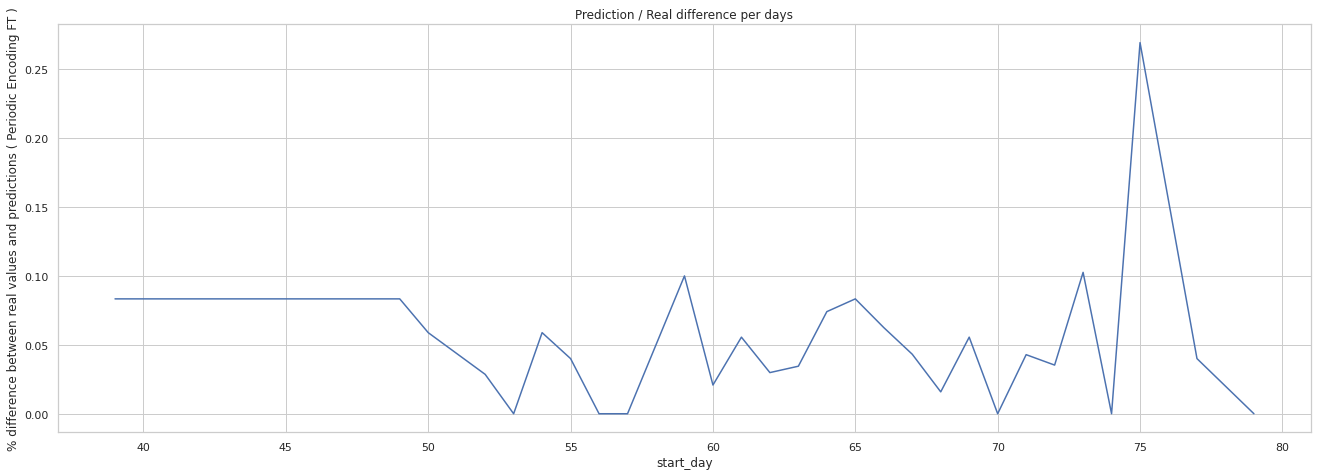

In [ ]:
test_copy = df.loc[(df.dataset == "test") & (df.duration.notnull())].copy()
test_copy["preds"] = periodic_tuned_test_preds['output'].ravel()
test_copy["daily_preds_sum"] = test_copy.groupby("start_day")["preds"].transform("sum").astype(int)
test_copy["daily_real_sum"] = test_copy.groupby("start_day")["duration"].transform("sum")
temp = test_copy.drop_duplicates(subset = ["start_day", "daily_preds_sum", "daily_real_sum"])[["start_day", "daily_preds_sum", "daily_real_sum"]].sort_values("start_day")
temp["daily_difference"] = abs(temp["daily_real_sum"] - temp["daily_preds_sum"])/temp.daily_real_sum
plt.figure(figsize = (20,7))
sns.lineplot(x = temp.start_day, y = temp.daily_difference)
plt.title("Prediction / Real difference per days")
plt.ylabel("% difference between real values and predictions ( Periodic Encoding FT )")

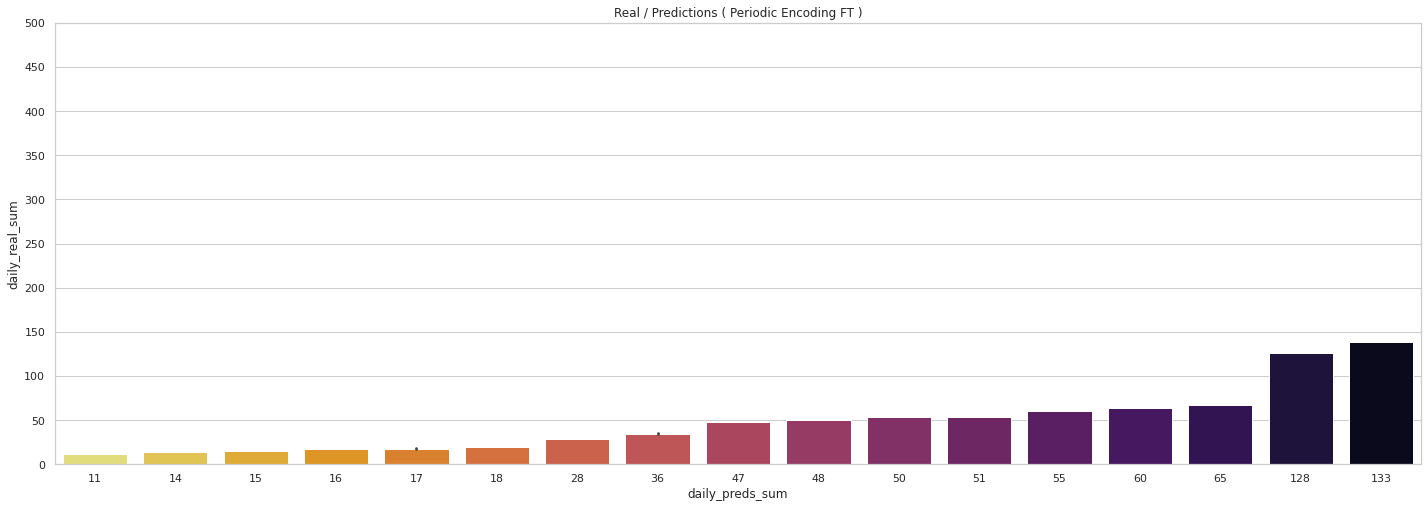

In [ ]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.daily_preds_sum[:20], y = temp.daily_real_sum[:20], palette = "inferno_r")
plt.tight_layout()
plt.yticks(np.arange(0,550,50))
plt.title("Real / Predictions ( Periodic Encoding FT )")
plt.show()

Text(0.5, 1.0, 'Daily differences between real values and predictions ( Periodic Encoding FT )')

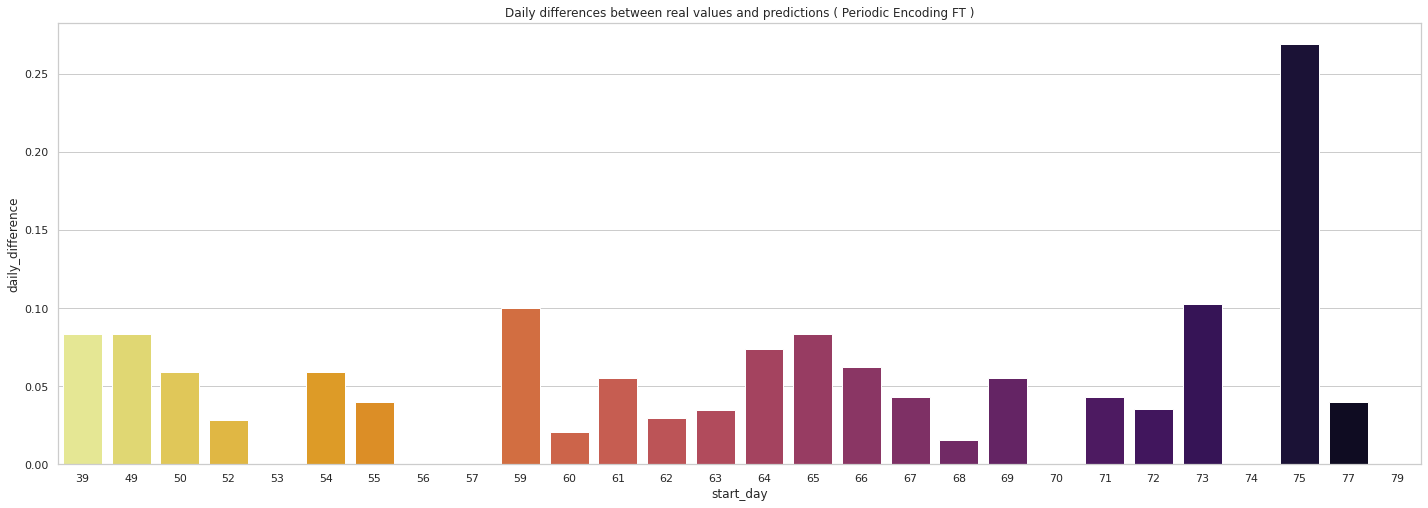

In [ ]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.start_day, y =temp.daily_difference, palette = "inferno_r")
plt.tight_layout()
plt.title("Daily differences between real values and predictions ( Periodic Encoding FT )")

### Linear Encoding Parameter Optimization

In [ ]:
import optuna
import gc

def objective(trial):
    ft_encoder = FTTransformerEncoder(
        numerical_features = NUMERIC_FEATURES,
        categorical_features =CATEGORICAL_FEATURES,
        numerical_data = X_train[NUMERIC_FEATURES].values,
        categorical_data = X_train[CATEGORICAL_FEATURES].values,
        y = X_train[LABEL].values,
        numerical_embedding_type='linear',
        numerical_bins=trial.suggest_int('numerical_bins', 20, 200),
        embedding_dim=trial.suggest_int('embedding_dim', 8, 100),
        depth=trial.suggest_int('depth', 1, 6),
        heads=trial.suggest_int('heads', 2, 8),
        attn_dropout=trial.suggest_float('attn_dropout', 0., 0.5),
        ff_dropout=trial.suggest_float('ff_dropout', 0., 0.5),
        explainable=True
    )


    # Pass th encoder to the model
    ft_transformer = FTTransformer(
        encoder=ft_encoder,
        out_dim=1,
        out_activation="relu"
    )

    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 0.00001
    NUM_EPOCHS = 150

    optimizer = tfa.optimizers.AdamW(
            learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
        )

    ft_transformer.compile(
        optimizer = optimizer,
        loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
        metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
    )

    early = EarlyStopping(monitor="val_output_loss", mode="min", patience=20, restore_best_weights=True)
    callback_list = [early]

    ft_history = ft_transformer.fit(
        train_dataset, 
        epochs=NUM_EPOCHS, 
        validation_data=val_dataset,
        callbacks=callback_list
    ) 
    
    preds = ft_transformer.predict(test_dataset)
    
    rmse = mean_squared_error(test_data[LABEL], preds['output'].ravel(),squared=False)
    gc.collect()
    
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=15)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-01-26 07:31:07,141] A new study created in memory with name: no-name-2e95fc68-aed1-4c86-8f98-151b65113a27


Epoch 1/150
2/2 [==============================] - 6s 803ms/step - loss: 276.6232 - output_loss: 276.6232 - output_rmse: 16.6320 - val_loss: 168.0694 - val_output_loss: 168.0694 - val_output_rmse: 12.9642
Epoch 2/150
2/2 [==============================] - 0s 62ms/step - loss: 178.8301 - output_loss: 178.8301 - output_rmse: 13.3727 - val_loss: 139.6841 - val_output_loss: 139.6841 - val_output_rmse: 11.8188
Epoch 3/150
2/2 [==============================] - 0s 62ms/step - loss: 146.6657 - output_loss: 146.6657 - output_rmse: 12.1106 - val_loss: 125.7029 - val_output_loss: 125.7029 - val_output_rmse: 11.2117
Epoch 4/150
2/2 [==============================] - 0s 68ms/step - loss: 131.9817 - output_loss: 131.9817 - output_rmse: 11.4883 - val_loss: 118.4357 - val_output_loss: 118.4357 - val_output_rmse: 10.8828
Epoch 5/150
2/2 [==============================] - 0s 67ms/step - loss: 123.9795 - output_loss: 123.9795 - output_rmse: 11.1346 - val_loss: 113.5778 - val_output_loss: 113.5778 - val_

[I 2023-01-26 07:31:26,285] Trial 0 finished with value: 3.3504296329374403 and parameters: {'numerical_bins': 154, 'embedding_dim': 57, 'depth': 4, 'heads': 7, 'attn_dropout': 0.40483036265891564, 'ff_dropout': 0.08514125392101007}. Best is trial 0 with value: 3.3504296329374403.


Epoch 1/150
2/2 [==============================] - 8s 905ms/step - loss: 281.8795 - output_loss: 281.8795 - output_rmse: 16.7893 - val_loss: 276.1148 - val_output_loss: 276.1148 - val_output_rmse: 16.6167
Epoch 2/150
2/2 [==============================] - 0s 64ms/step - loss: 278.7719 - output_loss: 278.7719 - output_rmse: 16.6965 - val_loss: 256.6234 - val_output_loss: 256.6234 - val_output_rmse: 16.0195
Epoch 3/150
2/2 [==============================] - 0s 59ms/step - loss: 271.5402 - output_loss: 271.5402 - output_rmse: 16.4785 - val_loss: 235.2873 - val_output_loss: 235.2873 - val_output_rmse: 15.3391
Epoch 4/150
2/2 [==============================] - 0s 64ms/step - loss: 256.8434 - output_loss: 256.8434 - output_rmse: 16.0263 - val_loss: 223.1335 - val_output_loss: 223.1335 - val_output_rmse: 14.9377
Epoch 5/150
2/2 [==============================] - 0s 65ms/step - loss: 241.9858 - output_loss: 241.9858 - output_rmse: 15.5559 - val_loss: 214.0855 - val_output_loss: 214.0855 - val_

[I 2023-01-26 07:31:52,840] Trial 1 finished with value: 3.333897185299336 and parameters: {'numerical_bins': 58, 'embedding_dim': 20, 'depth': 5, 'heads': 3, 'attn_dropout': 0.09158485164263863, 'ff_dropout': 0.3794939341618074}. Best is trial 1 with value: 3.333897185299336.


Epoch 1/150
2/2 [==============================] - 5s 675ms/step - loss: 256.3931 - output_loss: 256.3931 - output_rmse: 16.0123 - val_loss: 111.5164 - val_output_loss: 111.5164 - val_output_rmse: 10.5601
Epoch 2/150
2/2 [==============================] - 0s 60ms/step - loss: 131.2396 - output_loss: 131.2396 - output_rmse: 11.4560 - val_loss: 71.2028 - val_output_loss: 71.2028 - val_output_rmse: 8.4382
Epoch 3/150
2/2 [==============================] - 0s 57ms/step - loss: 84.7225 - output_loss: 84.7225 - output_rmse: 9.2045 - val_loss: 54.9991 - val_output_loss: 54.9991 - val_output_rmse: 7.4161
Epoch 4/150
2/2 [==============================] - 0s 55ms/step - loss: 62.7065 - output_loss: 62.7065 - output_rmse: 7.9187 - val_loss: 41.9404 - val_output_loss: 41.9404 - val_output_rmse: 6.4761
Epoch 5/150
2/2 [==============================] - 0s 53ms/step - loss: 47.1391 - output_loss: 47.1391 - output_rmse: 6.8658 - val_loss: 33.3544 - val_output_loss: 33.3544 - val_output_rmse: 5.7753


[I 2023-01-26 07:32:07,450] Trial 2 finished with value: 3.3356809100617717 and parameters: {'numerical_bins': 25, 'embedding_dim': 99, 'depth': 3, 'heads': 6, 'attn_dropout': 0.3539785644817126, 'ff_dropout': 0.30967197769186094}. Best is trial 1 with value: 3.333897185299336.


Epoch 1/150
2/2 [==============================] - 7s 880ms/step - loss: 241.3646 - output_loss: 241.3646 - output_rmse: 15.5359 - val_loss: 56.6099 - val_output_loss: 56.6099 - val_output_rmse: 7.5240
Epoch 2/150
2/2 [==============================] - 0s 71ms/step - loss: 103.2068 - output_loss: 103.2068 - output_rmse: 10.1591 - val_loss: 19.8924 - val_output_loss: 19.8924 - val_output_rmse: 4.4601
Epoch 3/150
2/2 [==============================] - 0s 67ms/step - loss: 40.1227 - output_loss: 40.1227 - output_rmse: 6.3342 - val_loss: 11.6985 - val_output_loss: 11.6985 - val_output_rmse: 3.4203
Epoch 4/150
2/2 [==============================] - 0s 65ms/step - loss: 19.8873 - output_loss: 19.8873 - output_rmse: 4.4595 - val_loss: 9.1980 - val_output_loss: 9.1980 - val_output_rmse: 3.0328
Epoch 5/150
2/2 [==============================] - 0s 73ms/step - loss: 11.4916 - output_loss: 11.4916 - output_rmse: 3.3899 - val_loss: 8.5981 - val_output_loss: 8.5981 - val_output_rmse: 2.9323
Epoch 6

[I 2023-01-26 07:32:19,574] Trial 3 finished with value: 3.3542398671575895 and parameters: {'numerical_bins': 162, 'embedding_dim': 100, 'depth': 5, 'heads': 2, 'attn_dropout': 0.3898528253025484, 'ff_dropout': 0.4915636202376631}. Best is trial 1 with value: 3.333897185299336.


Epoch 1/150
2/2 [==============================] - 6s 812ms/step - loss: 279.3149 - output_loss: 279.3149 - output_rmse: 16.7127 - val_loss: 245.0703 - val_output_loss: 245.0703 - val_output_rmse: 15.6547
Epoch 2/150
2/2 [==============================] - 0s 55ms/step - loss: 268.9019 - output_loss: 268.9019 - output_rmse: 16.3982 - val_loss: 222.0626 - val_output_loss: 222.0626 - val_output_rmse: 14.9018
Epoch 3/150
2/2 [==============================] - 0s 55ms/step - loss: 253.9086 - output_loss: 253.9086 - output_rmse: 15.9345 - val_loss: 209.2073 - val_output_loss: 209.2073 - val_output_rmse: 14.4640
Epoch 4/150
2/2 [==============================] - 0s 57ms/step - loss: 237.3309 - output_loss: 237.3309 - output_rmse: 15.4055 - val_loss: 199.9941 - val_output_loss: 199.9941 - val_output_rmse: 14.1419
Epoch 5/150
2/2 [==============================] - 0s 60ms/step - loss: 221.6433 - output_loss: 221.6433 - output_rmse: 14.8877 - val_loss: 193.0005 - val_output_loss: 193.0005 - val_

[I 2023-01-26 07:32:39,676] Trial 4 finished with value: 3.3485151042623453 and parameters: {'numerical_bins': 129, 'embedding_dim': 23, 'depth': 4, 'heads': 2, 'attn_dropout': 0.3333900027750068, 'ff_dropout': 0.3560928026064411}. Best is trial 1 with value: 3.333897185299336.


Epoch 1/150
2/2 [==============================] - 8s 959ms/step - loss: 266.4110 - output_loss: 266.4110 - output_rmse: 16.3221 - val_loss: 187.9993 - val_output_loss: 187.9993 - val_output_rmse: 13.7113
Epoch 2/150
2/2 [==============================] - 0s 73ms/step - loss: 212.0264 - output_loss: 212.0264 - output_rmse: 14.5611 - val_loss: 167.2964 - val_output_loss: 167.2964 - val_output_rmse: 12.9343
Epoch 3/150
2/2 [==============================] - 0s 72ms/step - loss: 184.5816 - output_loss: 184.5816 - output_rmse: 13.5861 - val_loss: 155.4210 - val_output_loss: 155.4210 - val_output_rmse: 12.4668
Epoch 4/150
2/2 [==============================] - 0s 67ms/step - loss: 168.2987 - output_loss: 168.2987 - output_rmse: 12.9730 - val_loss: 147.0293 - val_output_loss: 147.0293 - val_output_rmse: 12.1256
Epoch 5/150
2/2 [==============================] - 0s 67ms/step - loss: 156.4948 - output_loss: 156.4948 - output_rmse: 12.5098 - val_loss: 138.0475 - val_output_loss: 138.0475 - val_

[I 2023-01-26 07:33:00,741] Trial 5 finished with value: 3.3474212805405057 and parameters: {'numerical_bins': 67, 'embedding_dim': 29, 'depth': 5, 'heads': 7, 'attn_dropout': 0.26043014944010956, 'ff_dropout': 0.3609236214366388}. Best is trial 1 with value: 3.333897185299336.


Epoch 1/150
2/2 [==============================] - 6s 816ms/step - loss: 266.5460 - output_loss: 266.5460 - output_rmse: 16.3262 - val_loss: 89.1380 - val_output_loss: 89.1380 - val_output_rmse: 9.4413
Epoch 2/150
2/2 [==============================] - 0s 70ms/step - loss: 125.7728 - output_loss: 125.7728 - output_rmse: 11.2148 - val_loss: 46.1630 - val_output_loss: 46.1630 - val_output_rmse: 6.7943
Epoch 3/150
2/2 [==============================] - 0s 64ms/step - loss: 65.0170 - output_loss: 65.0170 - output_rmse: 8.0633 - val_loss: 32.3083 - val_output_loss: 32.3083 - val_output_rmse: 5.6840
Epoch 4/150
2/2 [==============================] - 0s 69ms/step - loss: 41.5034 - output_loss: 41.5034 - output_rmse: 6.4423 - val_loss: 26.4282 - val_output_loss: 26.4282 - val_output_rmse: 5.1408
Epoch 5/150
2/2 [==============================] - 0s 70ms/step - loss: 30.8293 - output_loss: 30.8293 - output_rmse: 5.5524 - val_loss: 22.5064 - val_output_loss: 22.5064 - val_output_rmse: 4.7441
Epo

[I 2023-01-26 07:33:14,457] Trial 6 finished with value: 3.3374494586814563 and parameters: {'numerical_bins': 171, 'embedding_dim': 97, 'depth': 4, 'heads': 5, 'attn_dropout': 0.1433132862597944, 'ff_dropout': 0.4824066653826285}. Best is trial 1 with value: 3.333897185299336.


Epoch 1/150
2/2 [==============================] - 8s 977ms/step - loss: 262.1460 - output_loss: 262.1460 - output_rmse: 16.1909 - val_loss: 190.8280 - val_output_loss: 190.8280 - val_output_rmse: 13.8141
Epoch 2/150
2/2 [==============================] - 0s 70ms/step - loss: 210.8172 - output_loss: 210.8172 - output_rmse: 14.5195 - val_loss: 175.2110 - val_output_loss: 175.2110 - val_output_rmse: 13.2367
Epoch 3/150
2/2 [==============================] - 0s 65ms/step - loss: 190.3341 - output_loss: 190.3341 - output_rmse: 13.7962 - val_loss: 165.5480 - val_output_loss: 165.5480 - val_output_rmse: 12.8665
Epoch 4/150
2/2 [==============================] - 0s 68ms/step - loss: 177.9639 - output_loss: 177.9639 - output_rmse: 13.3403 - val_loss: 157.1115 - val_output_loss: 157.1115 - val_output_rmse: 12.5344
Epoch 5/150
2/2 [==============================] - 0s 67ms/step - loss: 167.7653 - output_loss: 167.7653 - output_rmse: 12.9524 - val_loss: 149.2658 - val_output_loss: 149.2658 - val_

[I 2023-01-26 07:33:37,180] Trial 7 finished with value: 3.3478782347386424 and parameters: {'numerical_bins': 35, 'embedding_dim': 20, 'depth': 5, 'heads': 8, 'attn_dropout': 0.22102936480054797, 'ff_dropout': 0.2710733268568977}. Best is trial 1 with value: 3.333897185299336.


Epoch 1/150
2/2 [==============================] - 5s 695ms/step - loss: 280.0543 - output_loss: 280.0543 - output_rmse: 16.7348 - val_loss: 152.7901 - val_output_loss: 152.7901 - val_output_rmse: 12.3608
Epoch 2/150
2/2 [==============================] - 0s 59ms/step - loss: 186.6839 - output_loss: 186.6839 - output_rmse: 13.6632 - val_loss: 97.6135 - val_output_loss: 97.6135 - val_output_rmse: 9.8800
Epoch 3/150
2/2 [==============================] - 0s 57ms/step - loss: 118.1914 - output_loss: 118.1914 - output_rmse: 10.8716 - val_loss: 75.0508 - val_output_loss: 75.0508 - val_output_rmse: 8.6632
Epoch 4/150
2/2 [==============================] - 0s 55ms/step - loss: 87.5204 - output_loss: 87.5204 - output_rmse: 9.3552 - val_loss: 61.5277 - val_output_loss: 61.5277 - val_output_rmse: 7.8440
Epoch 5/150
2/2 [==============================] - 0s 54ms/step - loss: 69.8480 - output_loss: 69.8480 - output_rmse: 8.3575 - val_loss: 53.7445 - val_output_loss: 53.7445 - val_output_rmse: 7.33

[I 2023-01-26 07:33:49,746] Trial 8 finished with value: 3.353675528239948 and parameters: {'numerical_bins': 22, 'embedding_dim': 96, 'depth': 3, 'heads': 3, 'attn_dropout': 0.29245348101115465, 'ff_dropout': 0.323508305880598}. Best is trial 1 with value: 3.333897185299336.


Epoch 1/150
2/2 [==============================] - 4s 552ms/step - loss: 281.7077 - output_loss: 281.7077 - output_rmse: 16.7841 - val_loss: 268.5050 - val_output_loss: 268.5050 - val_output_rmse: 16.3861
Epoch 2/150
2/2 [==============================] - 0s 42ms/step - loss: 276.6276 - output_loss: 276.6276 - output_rmse: 16.6321 - val_loss: 242.5308 - val_output_loss: 242.5308 - val_output_rmse: 15.5734
Epoch 3/150
2/2 [==============================] - 0s 39ms/step - loss: 259.5270 - output_loss: 259.5270 - output_rmse: 16.1098 - val_loss: 227.6134 - val_output_loss: 227.6134 - val_output_rmse: 15.0869
Epoch 4/150
2/2 [==============================] - 0s 40ms/step - loss: 245.5973 - output_loss: 245.5973 - output_rmse: 15.6715 - val_loss: 217.8715 - val_output_loss: 217.8715 - val_output_rmse: 14.7605
Epoch 5/150
2/2 [==============================] - 0s 41ms/step - loss: 236.7786 - output_loss: 236.7786 - output_rmse: 15.3876 - val_loss: 210.2313 - val_output_loss: 210.2313 - val_

[I 2023-01-26 07:34:04,337] Trial 9 finished with value: 3.3456913422661283 and parameters: {'numerical_bins': 69, 'embedding_dim': 25, 'depth': 2, 'heads': 4, 'attn_dropout': 0.36163870247392677, 'ff_dropout': 0.4137959297821067}. Best is trial 1 with value: 3.333897185299336.


Epoch 1/150
2/2 [==============================] - 9s 1s/step - loss: 279.4459 - output_loss: 279.4459 - output_rmse: 16.7166 - val_loss: 167.3023 - val_output_loss: 167.3023 - val_output_rmse: 12.9345
Epoch 2/150
2/2 [==============================] - 0s 74ms/step - loss: 189.8413 - output_loss: 189.8413 - output_rmse: 13.7783 - val_loss: 135.3242 - val_output_loss: 135.3242 - val_output_rmse: 11.6329
Epoch 3/150
2/2 [==============================] - 0s 74ms/step - loss: 149.2223 - output_loss: 149.2223 - output_rmse: 12.2157 - val_loss: 122.0291 - val_output_loss: 122.0291 - val_output_rmse: 11.0467
Epoch 4/150
2/2 [==============================] - 0s 74ms/step - loss: 132.9496 - output_loss: 132.9496 - output_rmse: 11.5304 - val_loss: 116.0921 - val_output_loss: 116.0921 - val_output_rmse: 10.7746
Epoch 5/150
2/2 [==============================] - 0s 82ms/step - loss: 125.4550 - output_loss: 125.4550 - output_rmse: 11.2007 - val_loss: 112.1311 - val_output_loss: 112.1311 - val_out

[I 2023-01-26 07:34:25,228] Trial 10 finished with value: 3.350689373674507 and parameters: {'numerical_bins': 100, 'embedding_dim': 48, 'depth': 6, 'heads': 4, 'attn_dropout': 0.01961959684065194, 'ff_dropout': 0.15688170795790582}. Best is trial 1 with value: 3.333897185299336.


Epoch 1/150
2/2 [==============================] - 3s 436ms/step - loss: 276.7922 - output_loss: 276.7922 - output_rmse: 16.6371 - val_loss: 141.8259 - val_output_loss: 141.8259 - val_output_rmse: 11.9091
Epoch 2/150
2/2 [==============================] - 0s 36ms/step - loss: 164.0024 - output_loss: 164.0024 - output_rmse: 12.8063 - val_loss: 103.8087 - val_output_loss: 103.8087 - val_output_rmse: 10.1887
Epoch 3/150
2/2 [==============================] - 0s 35ms/step - loss: 122.9319 - output_loss: 122.9319 - output_rmse: 11.0875 - val_loss: 78.6601 - val_output_loss: 78.6601 - val_output_rmse: 8.8691
Epoch 4/150
2/2 [==============================] - 0s 33ms/step - loss: 97.7830 - output_loss: 97.7830 - output_rmse: 9.8885 - val_loss: 61.2367 - val_output_loss: 61.2367 - val_output_rmse: 7.8254
Epoch 5/150
2/2 [==============================] - 0s 35ms/step - loss: 79.1698 - output_loss: 79.1698 - output_rmse: 8.8977 - val_loss: 48.5635 - val_output_loss: 48.5635 - val_output_rmse: 6

[I 2023-01-26 07:34:32,153] Trial 11 finished with value: 3.320825571459682 and parameters: {'numerical_bins': 56, 'embedding_dim': 73, 'depth': 1, 'heads': 6, 'attn_dropout': 0.48494100840044174, 'ff_dropout': 0.22715319878572954}. Best is trial 11 with value: 3.320825571459682.


Epoch 1/150
2/2 [==============================] - 3s 405ms/step - loss: 222.1291 - output_loss: 222.1291 - output_rmse: 14.9040 - val_loss: 106.5554 - val_output_loss: 106.5554 - val_output_rmse: 10.3226
Epoch 2/150
2/2 [==============================] - 0s 33ms/step - loss: 128.4762 - output_loss: 128.4762 - output_rmse: 11.3347 - val_loss: 79.1342 - val_output_loss: 79.1342 - val_output_rmse: 8.8957
Epoch 3/150
2/2 [==============================] - 0s 35ms/step - loss: 95.9300 - output_loss: 95.9300 - output_rmse: 9.7944 - val_loss: 59.4726 - val_output_loss: 59.4726 - val_output_rmse: 7.7118
Epoch 4/150
2/2 [==============================] - 0s 37ms/step - loss: 72.8139 - output_loss: 72.8139 - output_rmse: 8.5331 - val_loss: 44.2704 - val_output_loss: 44.2704 - val_output_rmse: 6.6536
Epoch 5/150
2/2 [==============================] - 0s 34ms/step - loss: 56.1359 - output_loss: 56.1359 - output_rmse: 7.4924 - val_loss: 32.6853 - val_output_loss: 32.6853 - val_output_rmse: 5.7171


[I 2023-01-26 07:34:38,050] Trial 12 finished with value: 3.3391470978420106 and parameters: {'numerical_bins': 68, 'embedding_dim': 73, 'depth': 1, 'heads': 5, 'attn_dropout': 0.4859731273944644, 'ff_dropout': 0.2155118602413085}. Best is trial 11 with value: 3.320825571459682.


Epoch 1/150
2/2 [==============================] - 3s 391ms/step - loss: 234.0342 - output_loss: 234.0342 - output_rmse: 15.2982 - val_loss: 116.7123 - val_output_loss: 116.7123 - val_output_rmse: 10.8033
Epoch 2/150
2/2 [==============================] - 0s 32ms/step - loss: 130.6801 - output_loss: 130.6801 - output_rmse: 11.4315 - val_loss: 72.7455 - val_output_loss: 72.7455 - val_output_rmse: 8.5291
Epoch 3/150
2/2 [==============================] - 0s 35ms/step - loss: 88.1183 - output_loss: 88.1183 - output_rmse: 9.3871 - val_loss: 49.9112 - val_output_loss: 49.9112 - val_output_rmse: 7.0648
Epoch 4/150
2/2 [==============================] - 0s 34ms/step - loss: 63.8160 - output_loss: 63.8160 - output_rmse: 7.9885 - val_loss: 35.2943 - val_output_loss: 35.2943 - val_output_rmse: 5.9409
Epoch 5/150
2/2 [==============================] - 0s 32ms/step - loss: 49.7841 - output_loss: 49.7841 - output_rmse: 7.0558 - val_loss: 25.9763 - val_output_loss: 25.9763 - val_output_rmse: 5.0967


[I 2023-01-26 07:34:47,134] Trial 13 finished with value: 2.284157211763002 and parameters: {'numerical_bins': 97, 'embedding_dim': 74, 'depth': 1, 'heads': 4, 'attn_dropout': 0.16170045940578065, 'ff_dropout': 0.2175741154608161}. Best is trial 13 with value: 2.284157211763002.


Epoch 1/150
2/2 [==============================] - 3s 397ms/step - loss: 220.4282 - output_loss: 220.4282 - output_rmse: 14.8468 - val_loss: 56.0428 - val_output_loss: 56.0428 - val_output_rmse: 7.4862
Epoch 2/150
2/2 [==============================] - 0s 33ms/step - loss: 79.8454 - output_loss: 79.8454 - output_rmse: 8.9356 - val_loss: 32.6715 - val_output_loss: 32.6715 - val_output_rmse: 5.7159
Epoch 3/150
2/2 [==============================] - 0s 33ms/step - loss: 49.5863 - output_loss: 49.5863 - output_rmse: 7.0418 - val_loss: 20.9067 - val_output_loss: 20.9067 - val_output_rmse: 4.5724
Epoch 4/150
2/2 [==============================] - 0s 40ms/step - loss: 33.1645 - output_loss: 33.1645 - output_rmse: 5.7589 - val_loss: 13.6157 - val_output_loss: 13.6157 - val_output_rmse: 3.6899
Epoch 5/150
2/2 [==============================] - 0s 33ms/step - loss: 23.2802 - output_loss: 23.2802 - output_rmse: 4.8250 - val_loss: 9.7736 - val_output_loss: 9.7736 - val_output_rmse: 3.1263
Epoch 6/

[I 2023-01-26 07:34:52,691] Trial 14 finished with value: 3.378248155657094 and parameters: {'numerical_bins': 100, 'embedding_dim': 78, 'depth': 1, 'heads': 6, 'attn_dropout': 0.482639047498874, 'ff_dropout': 0.209146602465934}. Best is trial 13 with value: 2.284157211763002.


Number of finished trials: 15
Best trial: {'numerical_bins': 97, 'embedding_dim': 74, 'depth': 1, 'heads': 4, 'attn_dropout': 0.16170045940578065, 'ff_dropout': 0.2175741154608161}


In [ ]:
study.best_trial.params

{'numerical_bins': 97,
 'embedding_dim': 74,
 'depth': 1,
 'heads': 4,
 'attn_dropout': 0.16170045940578065,
 'ff_dropout': 0.2175741154608161}

In [ ]:
ft_linear_encoder = FTTransformerEncoder(
    numerical_features = NUMERIC_FEATURES,
    categorical_features = CATEGORICAL_FEATURES,
    numerical_data = X_train[NUMERIC_FEATURES].values,
    categorical_data = X_train[CATEGORICAL_FEATURES].values,
    y = X_train[LABEL].values,
    numerical_embedding_type='linear',
    numerical_bins=97,
    embedding_dim=74,
    depth=4,
    heads=6,
    attn_dropout= 0.3852,
    ff_dropout= 0.06051,
    explainable=True
)

# Pass th encoder to the model
ft_linear_encoder_transformer = FTTransformer(
    encoder=ft_linear_encoder,
    out_dim=1,
    out_activation="relu",
)

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 250

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

ft_linear_encoder_transformer.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
    metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
)

early = EarlyStopping(monitor="val_output_loss", mode="min", patience=16, restore_best_weights=True)
callback_list = [early]

ft_linear_history = ft_linear_encoder_transformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/250
2/2 [==============================] - 6s 783ms/step - loss: 263.7583 - output_loss: 263.7583 - output_rmse: 16.2406 - val_loss: 146.6285 - val_output_loss: 146.6285 - val_output_rmse: 12.1090
Epoch 2/250
2/2 [==============================] - 0s 62ms/step - loss: 153.4586 - output_loss: 153.4586 - output_rmse: 12.3878 - val_loss: 111.9063 - val_output_loss: 111.9063 - val_output_rmse: 10.5786
Epoch 3/250
2/2 [==============================] - 0s 60ms/step - loss: 118.1172 - output_loss: 118.1172 - output_rmse: 10.8682 - val_loss: 98.1519 - val_output_loss: 98.1519 - val_output_rmse: 9.9072
Epoch 4/250
2/2 [==============================] - 0s 59ms/step - loss: 103.2552 - output_loss: 103.2552 - output_rmse: 10.1615 - val_loss: 91.0961 - val_output_loss: 91.0961 - val_output_rmse: 9.5444
Epoch 5/250
2/2 [==============================] - 0s 60ms/step - loss: 95.3501 - output_loss: 95.3501 - output_rmse: 9.7647 - val_loss: 86.8917 - val_output_loss: 86.8917 - val_output_rmse

In [ ]:
linear_tuned_test_preds = ft_linear_encoder_transformer.predict(test_dataset)
linear_tuned_rms = mean_squared_error(test_data[LABEL], linear_tuned_test_preds['output'].ravel(), squared=False)

1/1 [==============================] - 1s 670ms/step


In [ ]:
linear_tuned_test_preds = ft_linear_encoder_transformer.predict(test_dataset)
linear_tuned_rms = mean_squared_error(test_data[LABEL], linear_tuned_test_preds['output'].ravel(), squared=False)
linear_tuned_rms = mean_squared_error(test_data[LABEL], linear_tuned_test_preds['output'].ravel(), squared=False)
linear_tuned_mae = mae(test_data[LABEL], linear_tuned_test_preds['output'].ravel())
linear_tuned_r2 = r2_score(test_data[LABEL], linear_tuned_test_preds['output'].ravel())


1/1 [==============================] - 0s 14ms/step


### Tuned Linear Encoding - Transformer Model Graphs

Text(0, 0.5, '% difference between real values and predictions ( Linear Encoding FT )')

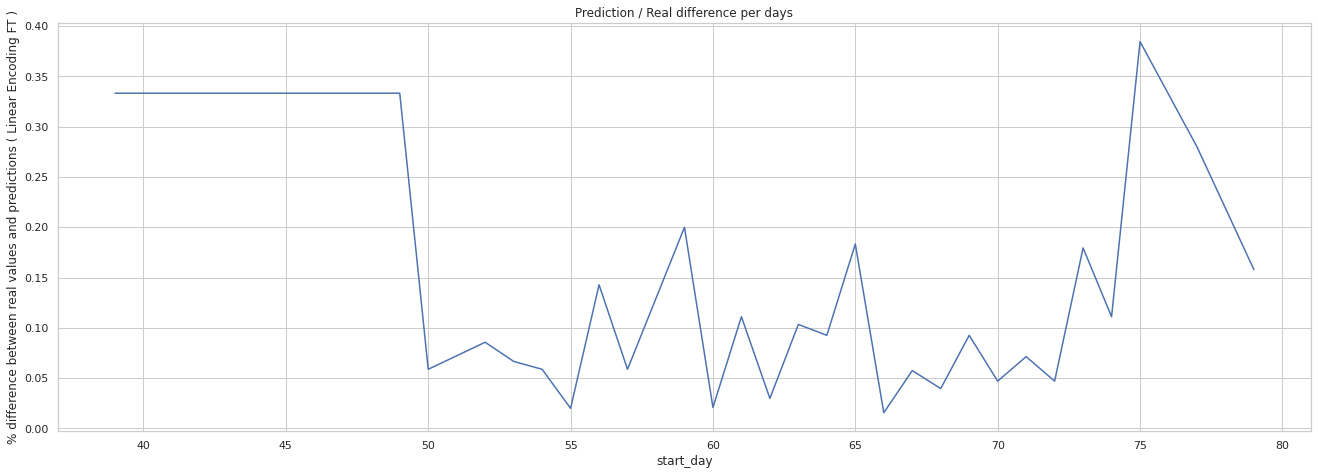

In [ ]:
test_copy = df.loc[(df.dataset == "test") & (df.duration.notnull())].copy()
test_copy["preds"] = linear_tuned_test_preds['output'].ravel()
test_copy["daily_preds_sum"] = test_copy.groupby("start_day")["preds"].transform("sum").astype(int)
test_copy["daily_real_sum"] = test_copy.groupby("start_day")["duration"].transform("sum")
temp = test_copy.drop_duplicates(subset = ["start_day", "daily_preds_sum", "daily_real_sum"])[["start_day", "daily_preds_sum", "daily_real_sum"]].sort_values("start_day")
temp["daily_difference"] = abs(temp["daily_real_sum"] - temp["daily_preds_sum"])/temp.daily_real_sum
plt.figure(figsize = (20,7))
sns.lineplot(x = temp.start_day, y = temp.daily_difference)
plt.title("Prediction / Real difference per days")
plt.ylabel("% difference between real values and predictions ( Linear Encoding FT )")

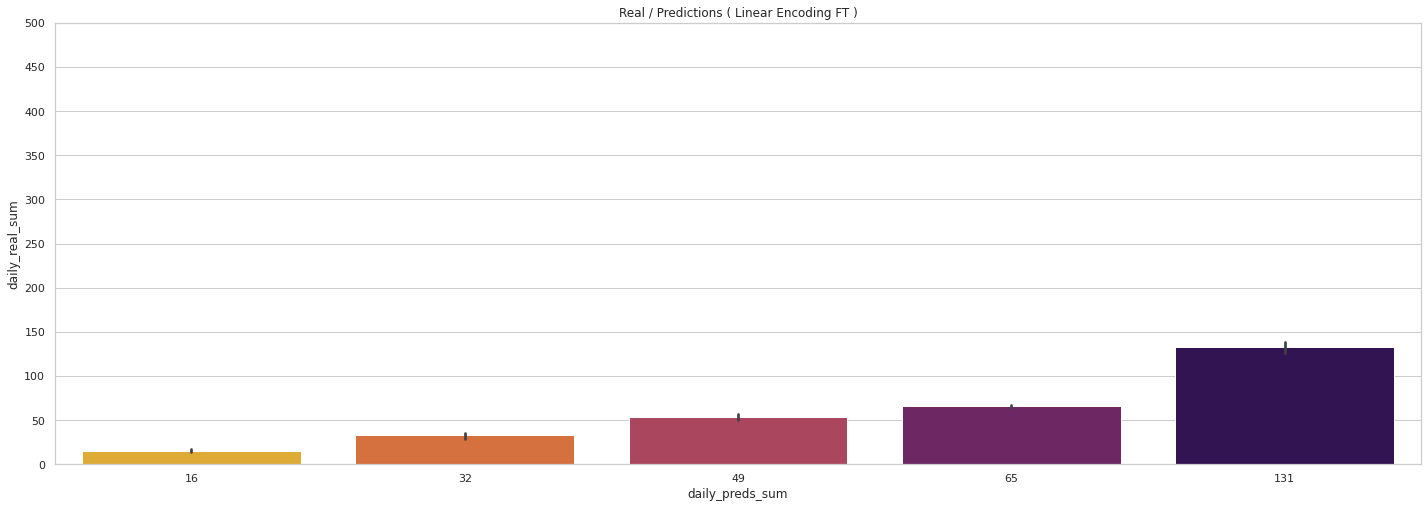

In [ ]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.daily_preds_sum[:20], y = temp.daily_real_sum[:20], palette = "inferno_r")
plt.tight_layout()
plt.yticks(np.arange(0,550,50))
plt.title("Real / Predictions ( Linear Encoding FT )")
plt.show()

Text(0.5, 1.0, 'Daily differences between real values and predictions ( Linear Encoding FT )')

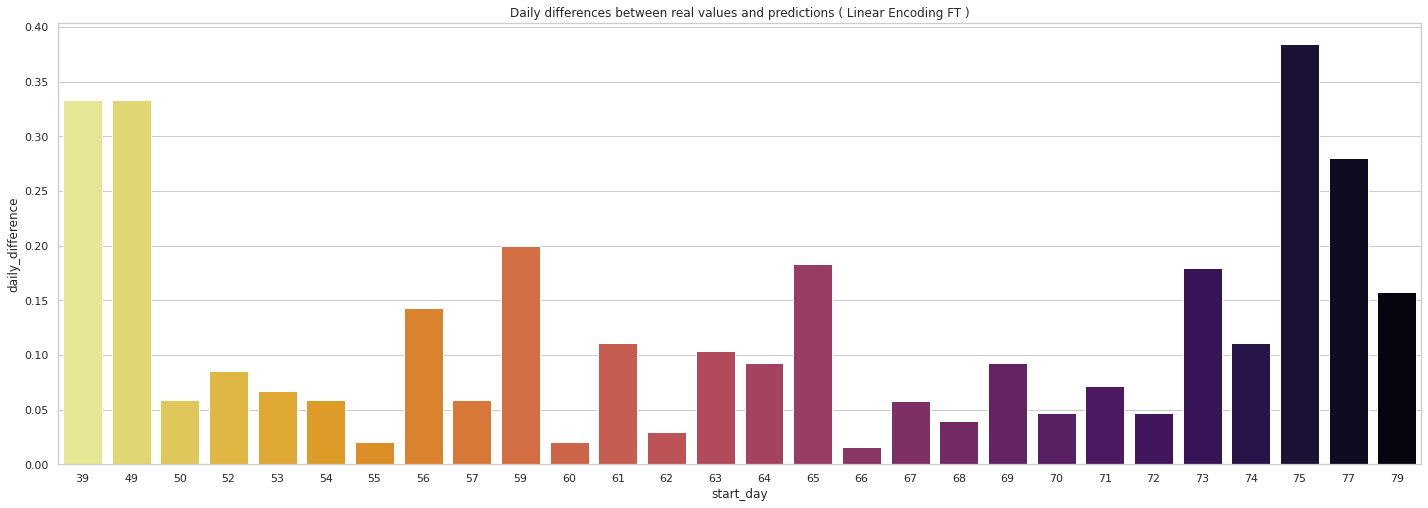

In [ ]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.start_day, y =temp.daily_difference, palette = "inferno_r")
plt.tight_layout()
plt.title("Daily differences between real values and predictions ( Linear Encoding FT )")

### Our results were like this :

In [ ]:
before_optimization = pd.DataFrame({"r2" : [linear_r2, periodic_r2, lgb_r2],
              "mae" : [linear_mae, period_mae, lgb_mae],
              "rmse" : [linear_rms, periodic_rms, lgb_rmse]}, index = ["Transformer - Linear Encoding", "Transformer - Periodic Encoding",
                     "LightGBM"]) # parameter needs more iterations
before_optimization

,r2,mae,rmse
Transformer - Linear Encoding,-0.029172,2.673975,3.351220
Transformer - Periodic Encoding,-0.029172,2.672771,3.349335
LightGBM,0.845670,0.745922,1.297730


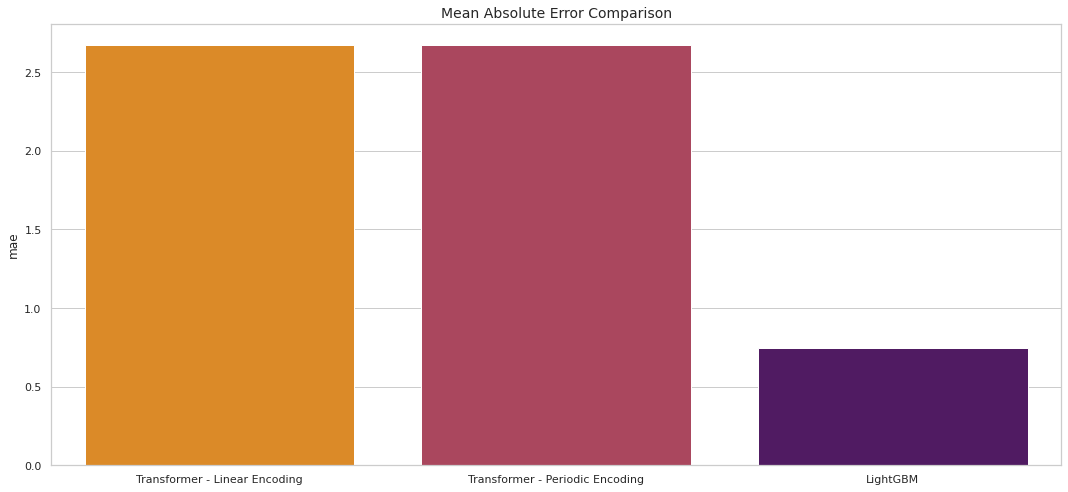

In [ ]:
plt.figure(figsize = (15,7))
sns.barplot(x = before_optimization.index, y = before_optimization.mae,palette = "inferno_r")
plt.title("Mean Absolute Error Comparison", fontsize = 14)
plt.tight_layout()


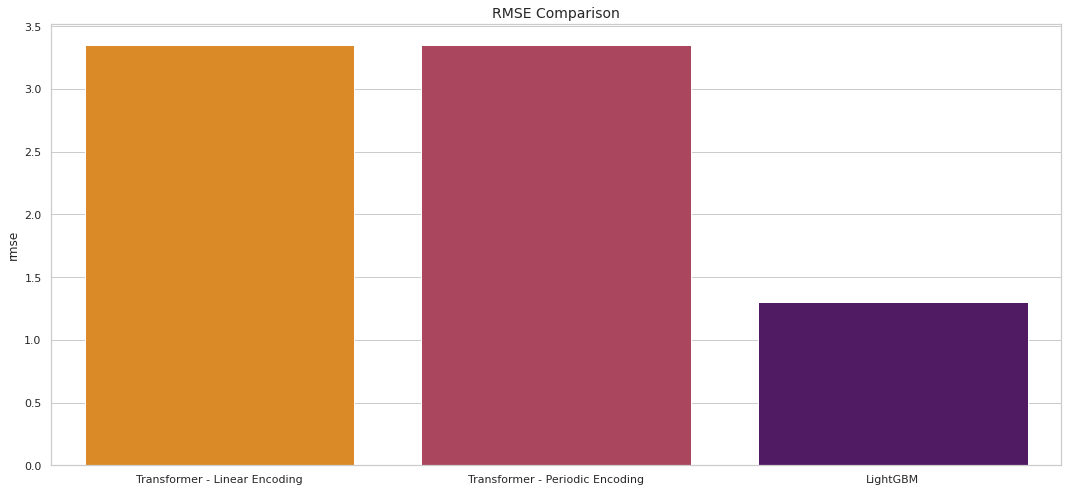

In [ ]:
plt.figure(figsize = (15,7))
sns.barplot(x = before_optimization.index, y = before_optimization.rmse,palette = "inferno_r")
plt.title("RMSE Comparison", fontsize = 14)
plt.tight_layout()


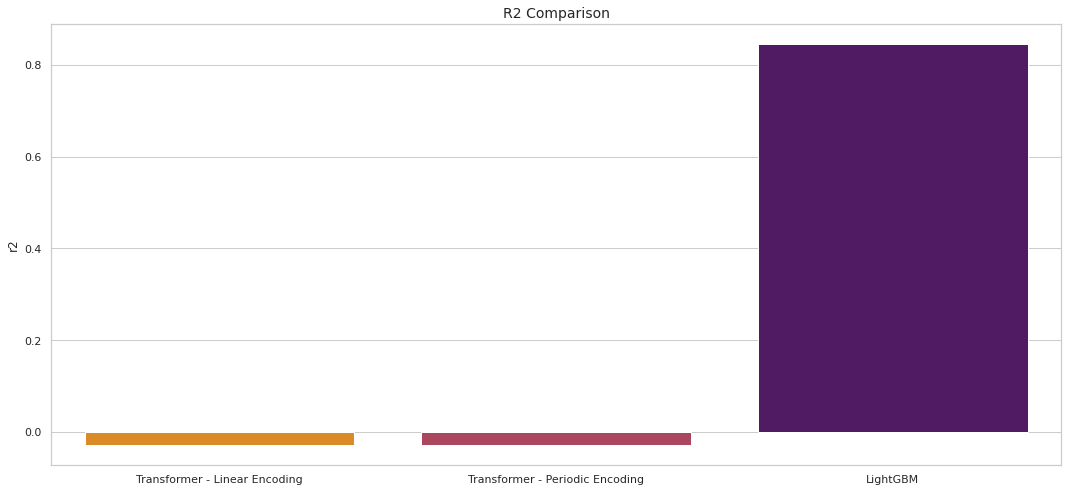

In [ ]:
plt.figure(figsize = (15,7))
sns.barplot(x = before_optimization.index, y = before_optimization.r2,palette = "inferno_r")
plt.title("R2 Comparison", fontsize = 14)
plt.tight_layout()


### After optimization:

In [ ]:
after_optimization = pd.DataFrame({"r2" : [linear_tuned_r2, periodic_tuned_r2, lgb_tuned_r2],
              "mae" : [linear_tuned_mae, periodic_tuned_mae, lgb_tuned_mae],
              "rmse" : [linear_tuned_rms, periodic_tuned_rms, lgb_tuned_rmse]}, index = ["Transformer - Linear Encoding TUNED", "Transformer - Periodic Encoding TUNED",
                     "LightGBM TUNED"]) # parameter needs more iterations
after_optimization

,r2,mae,rmse
Transformer - Linear Encoding TUNED,-0.026999,2.672177,3.347682
Transformer - Periodic Encoding TUNED,0.706008,1.102649,1.791130
LightGBM TUNED,0.813050,0.924762,1.428306


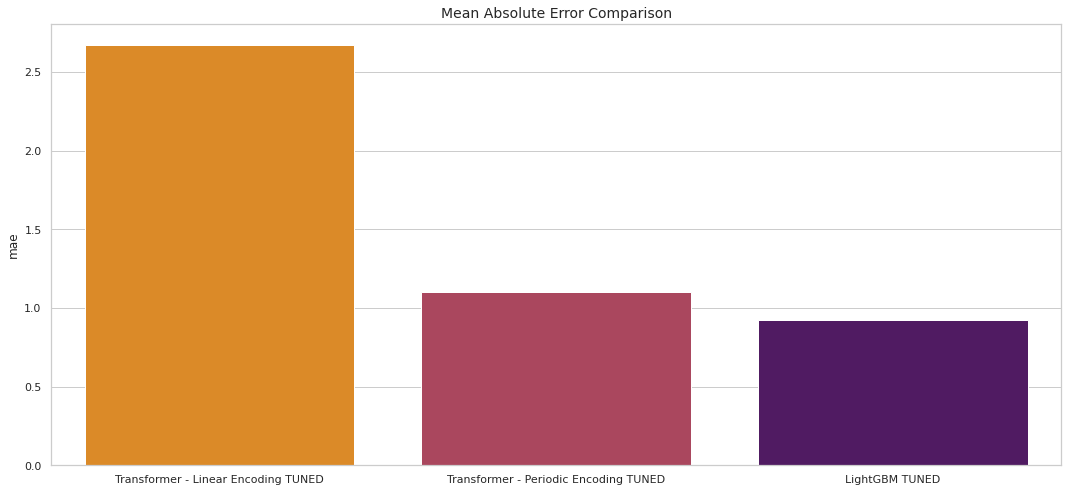

In [ ]:
plt.figure(figsize = (15,7))
sns.barplot(x = after_optimization.index, y = after_optimization.mae,palette = "inferno_r")
plt.title("Mean Absolute Error Comparison", fontsize = 14)
plt.tight_layout()


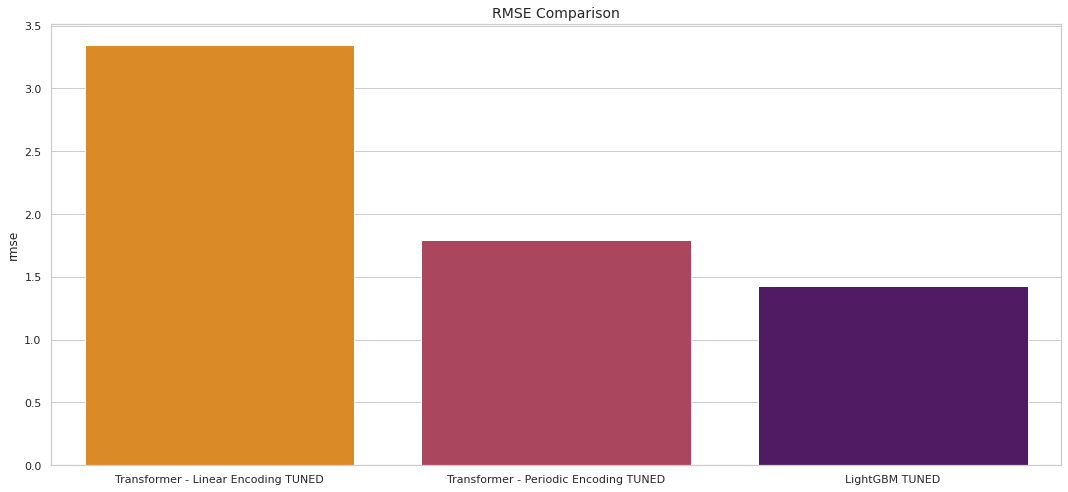

In [ ]:
plt.figure(figsize = (15,7))
sns.barplot(x = after_optimization.index, y = after_optimization.rmse,palette = "inferno_r")
plt.title("RMSE Comparison", fontsize = 14)
plt.tight_layout()


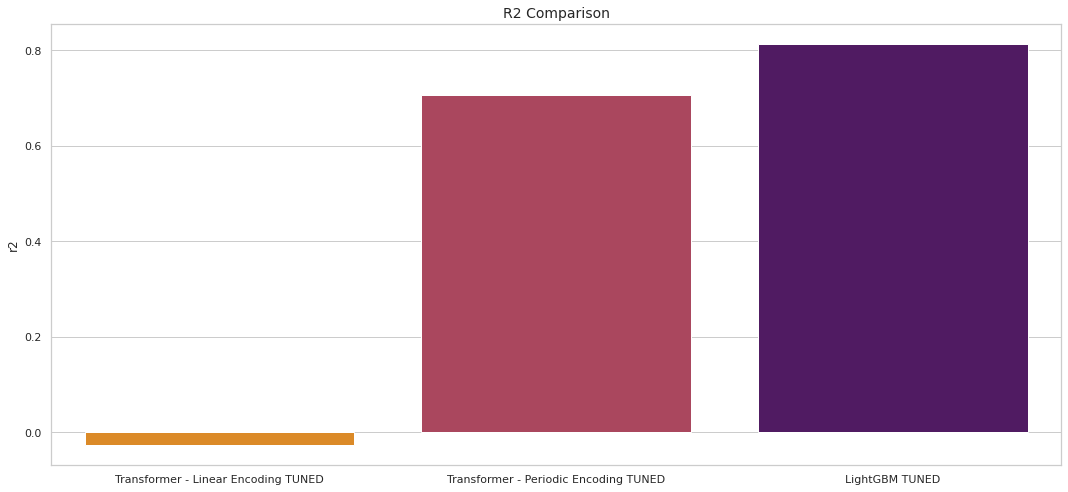

In [ ]:
plt.figure(figsize = (15,7))
sns.barplot(x = after_optimization.index, y = after_optimization.r2,palette = "inferno_r")
plt.title("R2 Comparison", fontsize = 14)
plt.tight_layout()
